Notes on what I did:
1) include all features in feature list
2) logically remove features that does not make sense in contribtion to identifying POI or not which are email address, other
3) copy evaluator from tester.py, use split train test for local testing, move to strat later
4) look at ranking of importance of features using decisiontree class
5) create fraction feature to and from poi emails and shared recipient emails
6) remove total from data. plot each variable to get feel. decided to keep outliers of moneny related since that is probably incentive of poi (one person super high loan advances and total payments and restricted stock deferred) and rmeoving them results in a worse classifier
7) binary tree all features gives 0 recall 0 precision - dont know if i can trust features ranking or not
8) tried svm - got divide error 0 when using default parameters
9) cannot remove nan values for salary since its 51/146
10) check all NaN values for the data dictionary for all features, going to remove features that have a high number of NaN (>50%) and they are director fees, loan_advances, restricted_stock_deferred, defferal_payments, deferred_income, long term incentive
11) choose not to rescale because presence outliers and choose not svm because it can be affected by outliers more. decide to use a form of decision tree since naive bayes is usually used for text and got better results with tree at default parameters
12) will try random forest or ada boost
13) create new features - frac and replace it with old features - decreased results
14) gaussian has good recall
15) grid search - n_estimators and max depth for random forest - we found that it overfits a lot
16) ada boost with tree has good precision and recall - suitable for smaller data

ideas:
evaluation should be high in accuracy, high f1 score but if cannot, better high in precision because you dont want to put in innocent people to jail for a long time
remove nan values for salary? or important features?

need to reiterate to find good features

In [28]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
from sklearn.feature_selection import SelectKBest, SelectPercentile 

features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'bonus',
                 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 
                 'long_term_incentive', 'restricted_stock', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
                 'shared_receipt_with_poi', 'director_fees'] 

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


In [29]:
### Task 2: Remove outliers

current=0
for key in data_dict.keys():  
    if data_dict[key]['salary']>current and data_dict[key]['salary']!='NaN':
        outlier=key
        current=data_dict[key]['salary']
    
print outlier,current
del data_dict[outlier]
# removed "Total"

TOTAL 26704229


In [22]:
import pandas as pd

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

test1 = pd.DataFrame(0, index=[0,1], columns=features_list[1:])
for i in range(len(features)):
    label = int(labels[i])
    for j in range(len(features[i])):
#         print(features[i][j])
        if features[i][j] == 0.0:
            test1.iloc[label,j] += 1
        
test1.T

,0,1
salary,49,1
deferral_payments,93,13
total_payments,20,0
bonus,61,2
deferred_income,89,7
total_stock_value,19,0
expenses,50,0
exercised_stock_options,37,6
long_term_incentive,73,6
restricted_stock,34,1


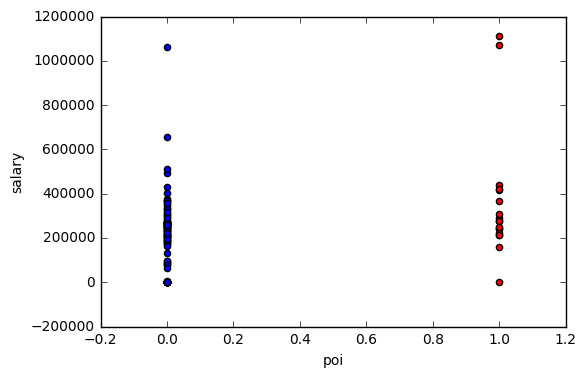

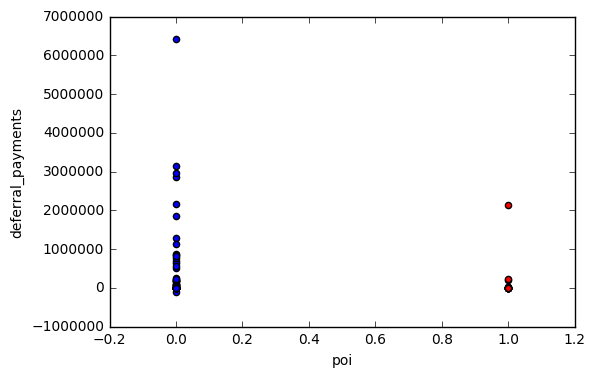

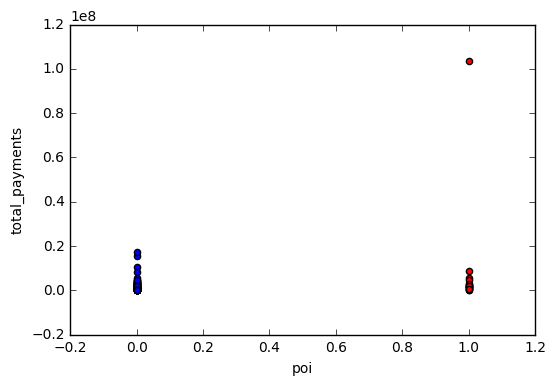

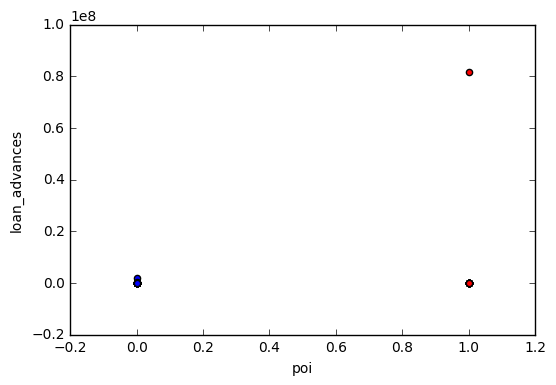

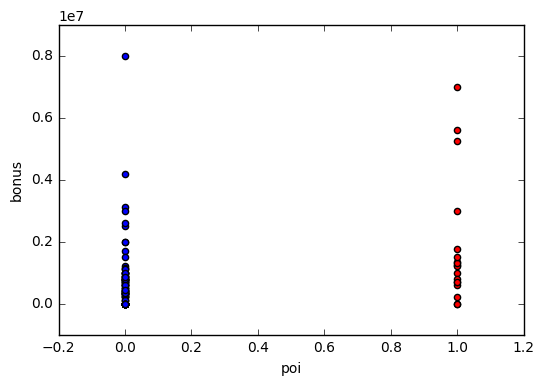

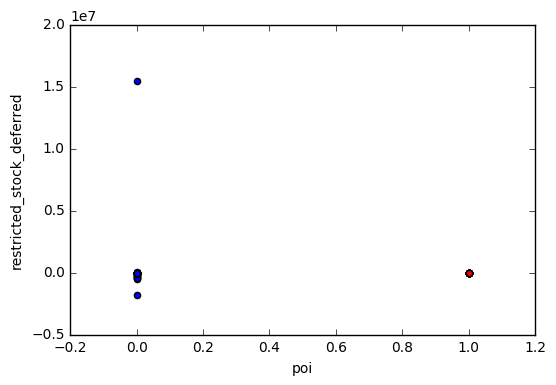

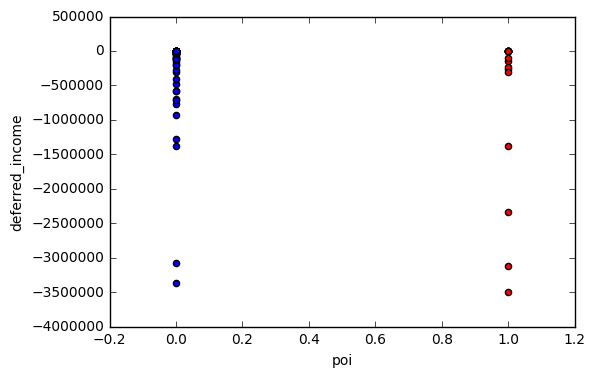

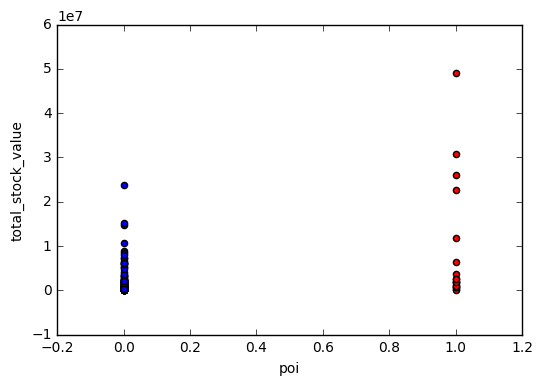

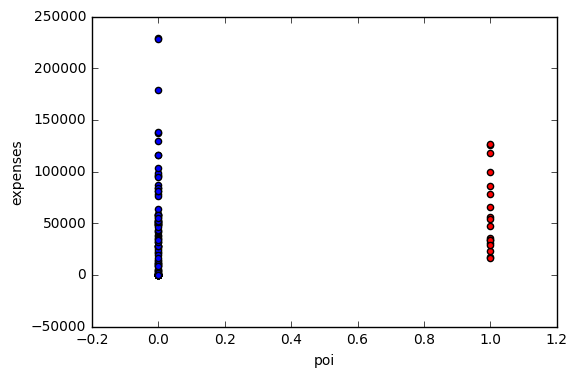

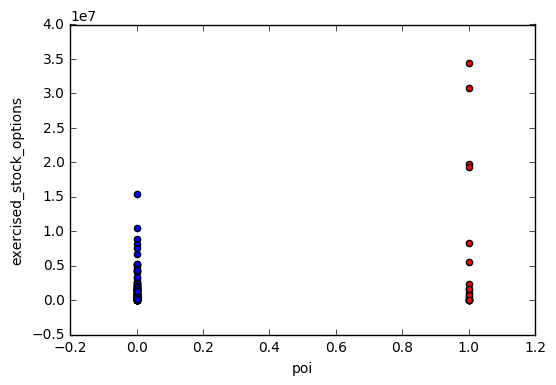

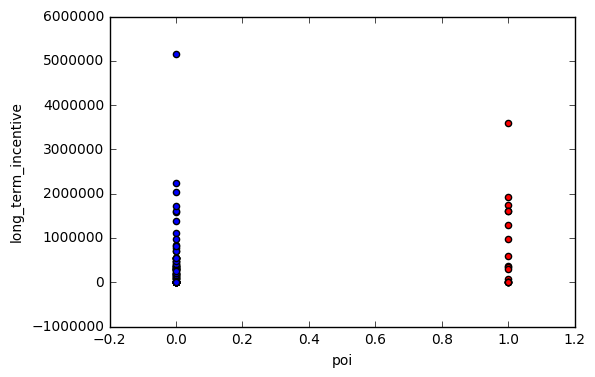

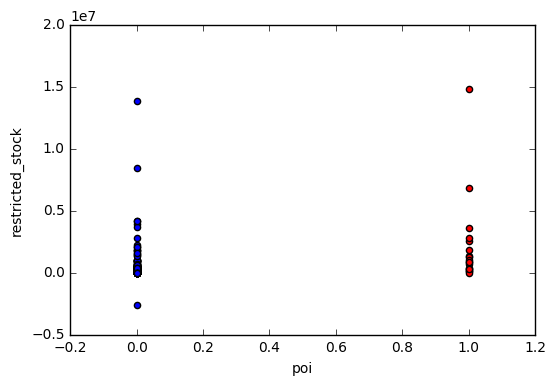

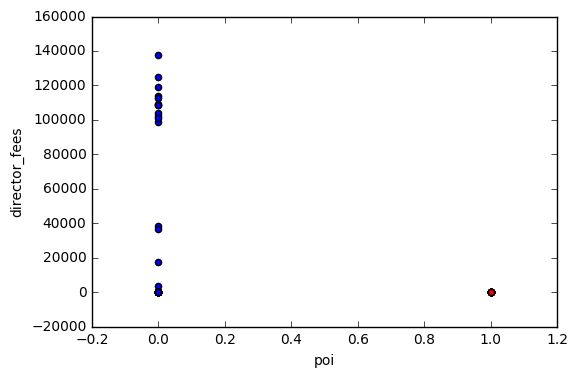

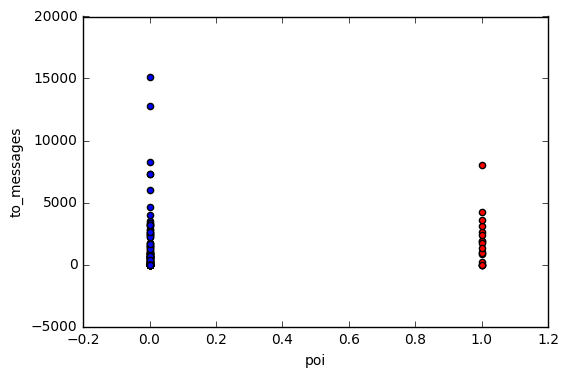

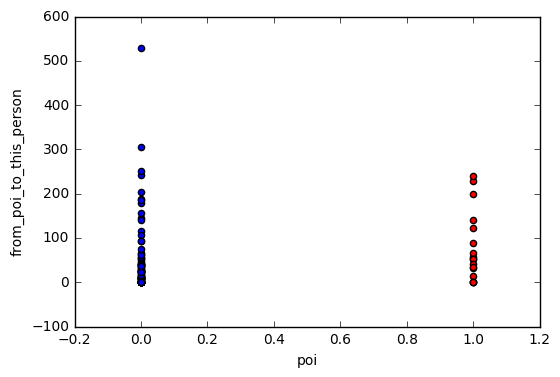

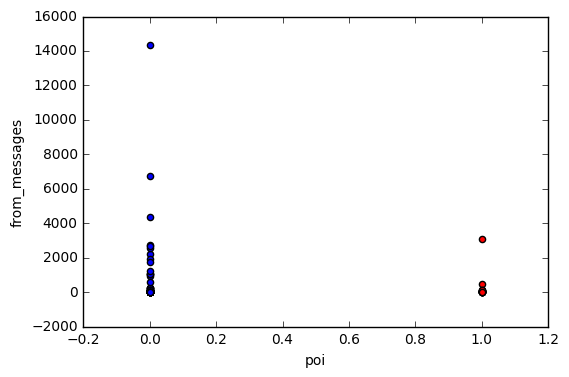

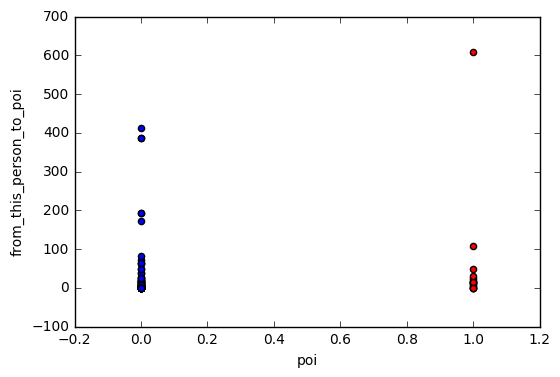

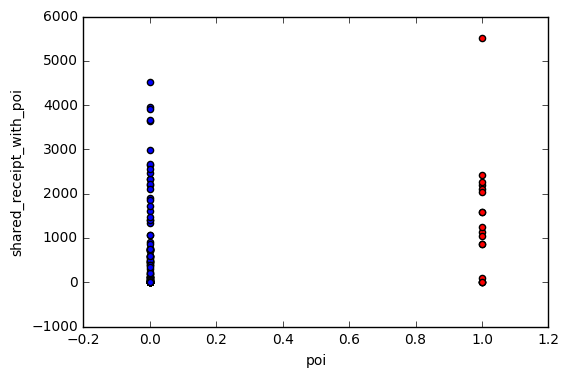

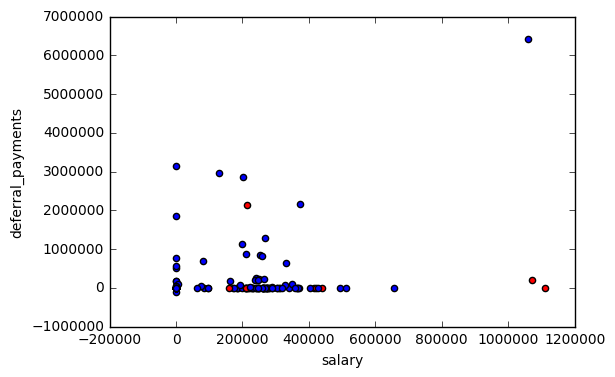

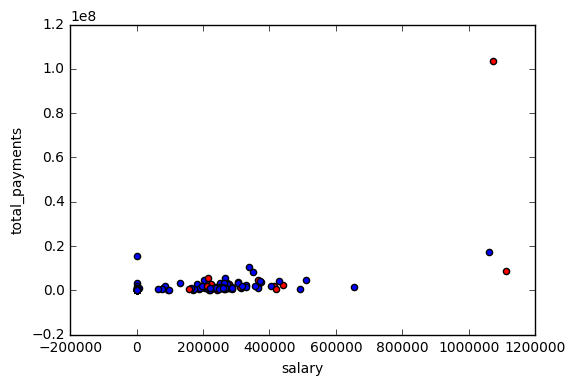

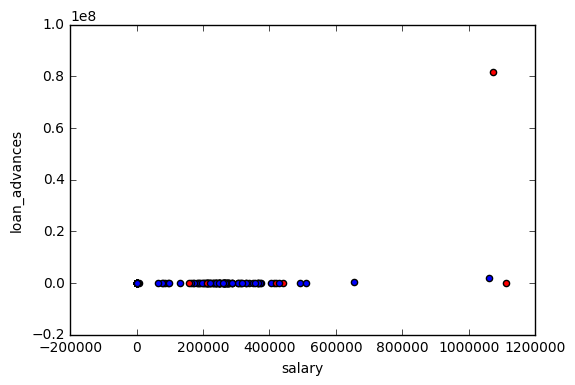

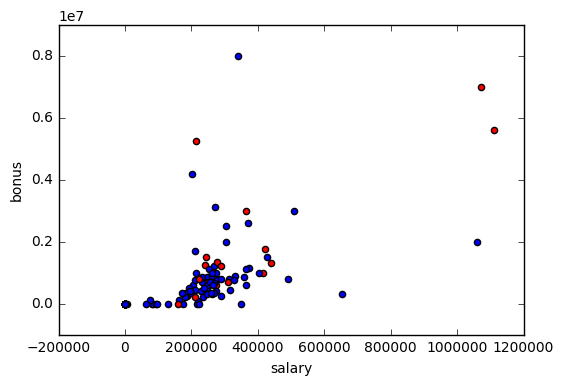

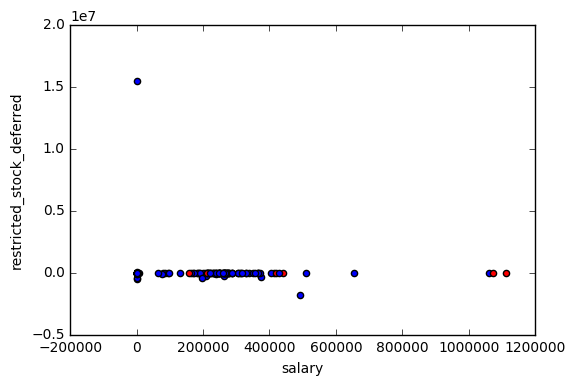

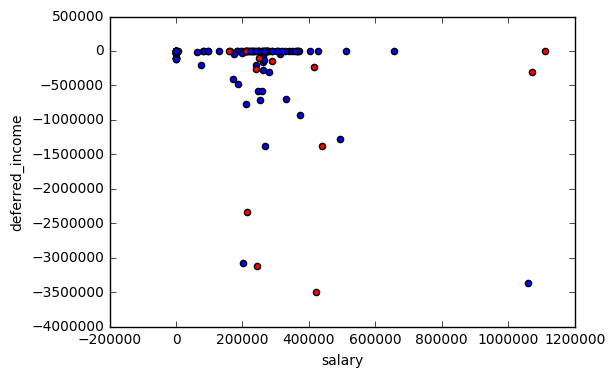

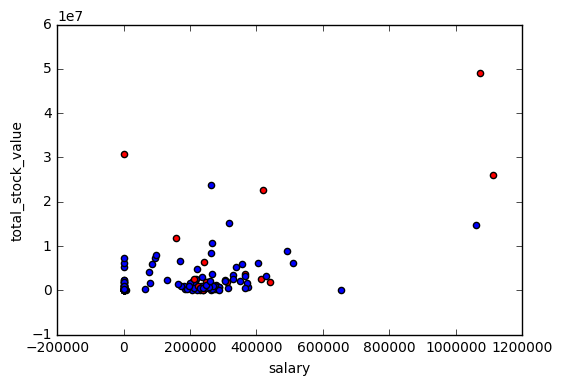

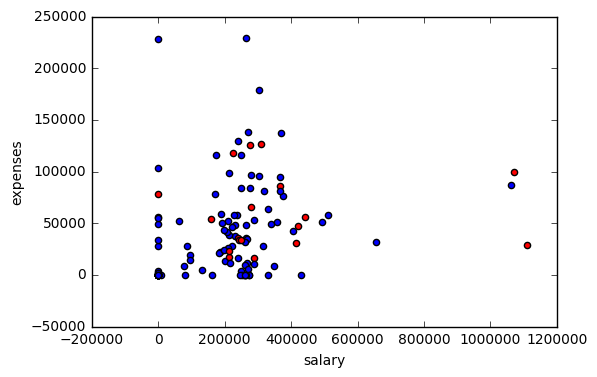

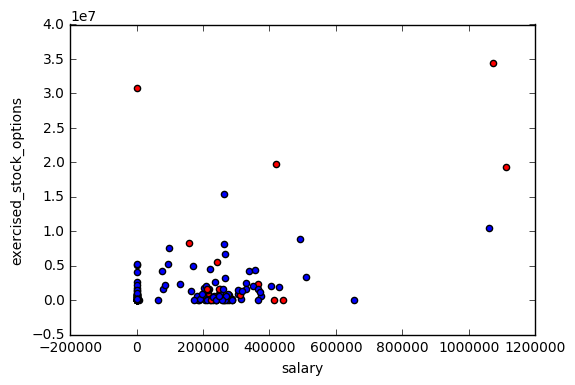

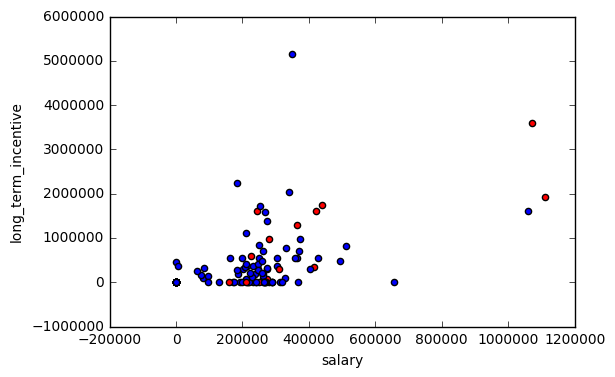

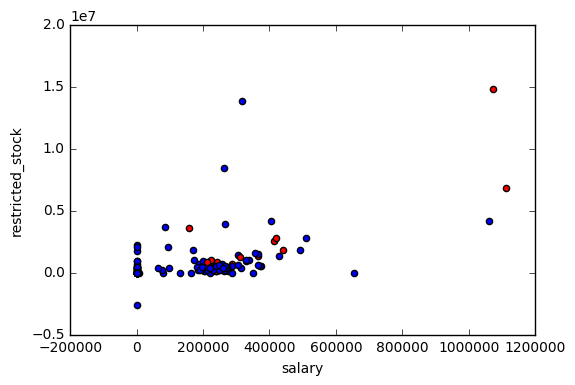

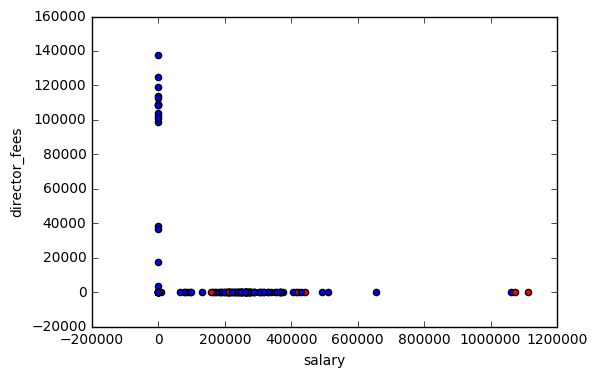

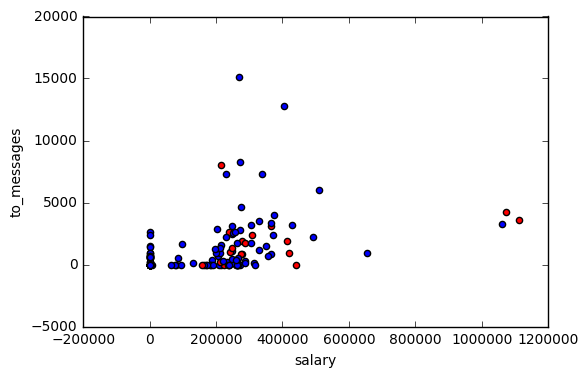

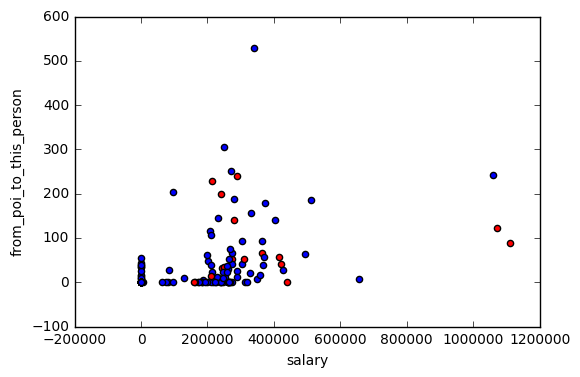

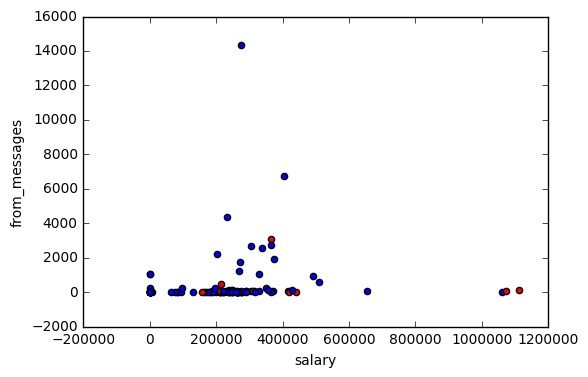

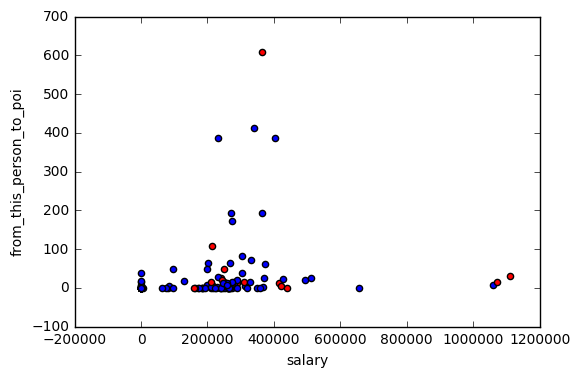

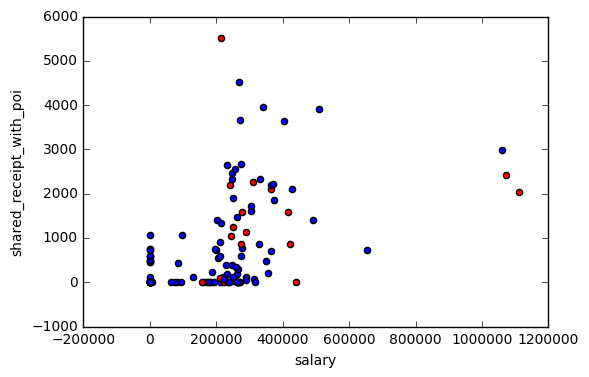

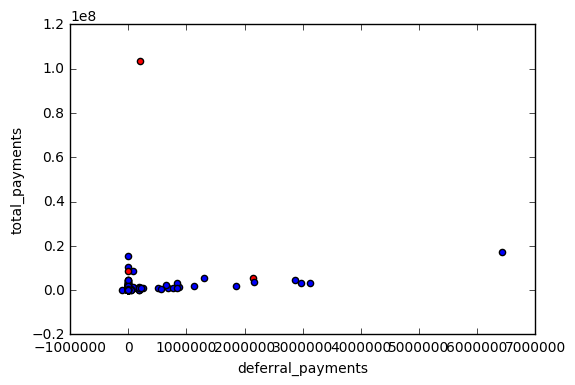

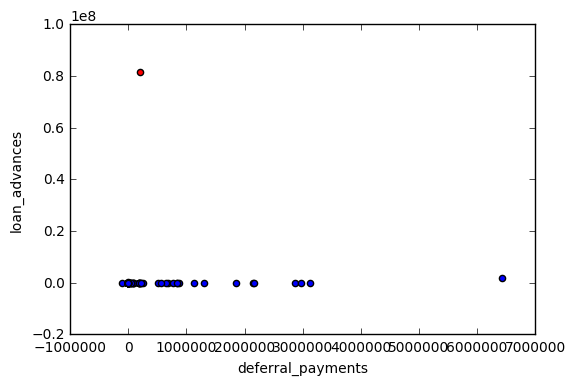

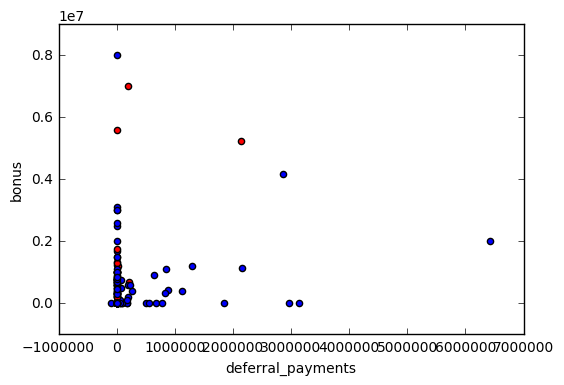

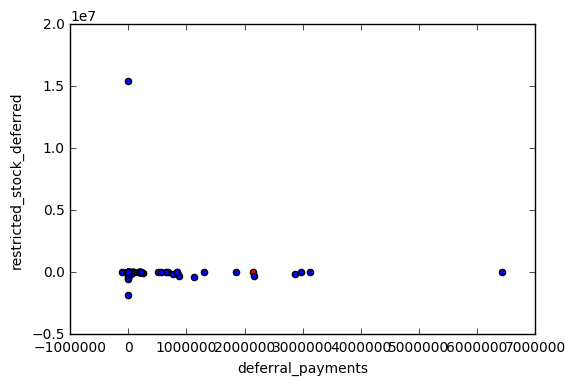

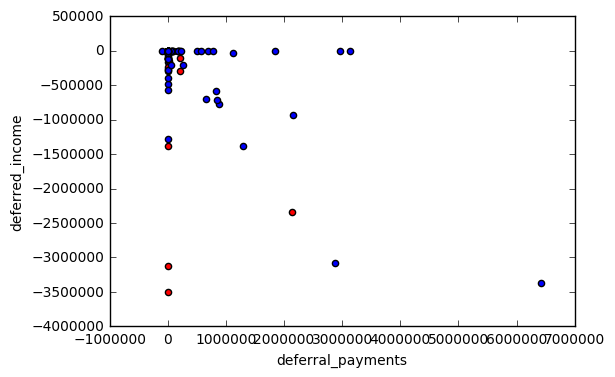

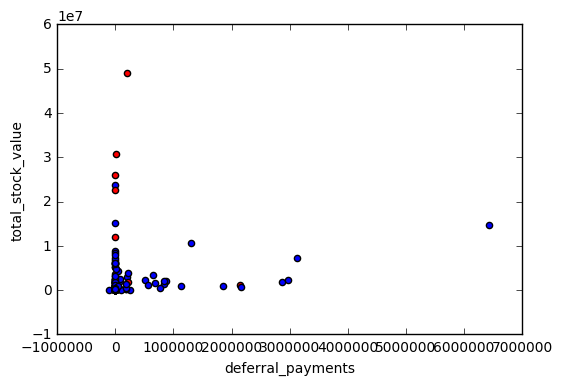

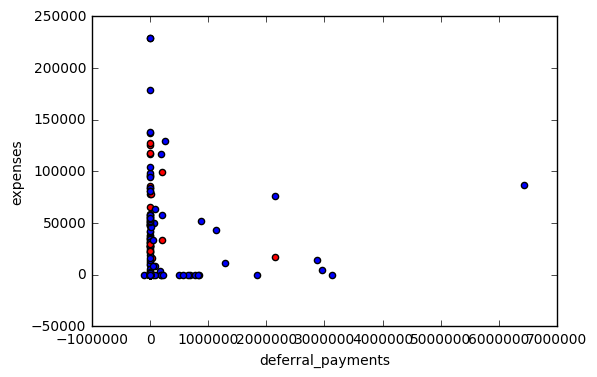

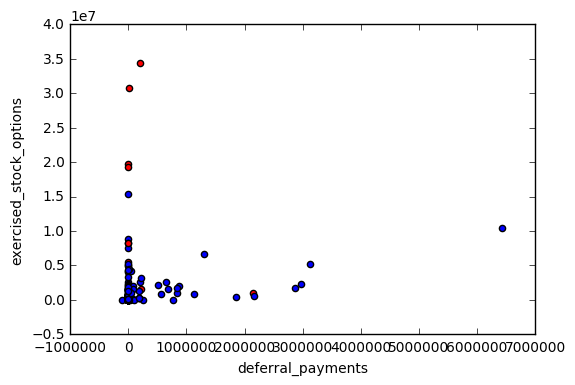

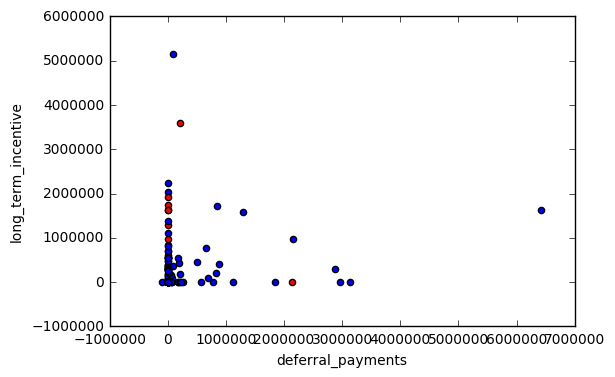

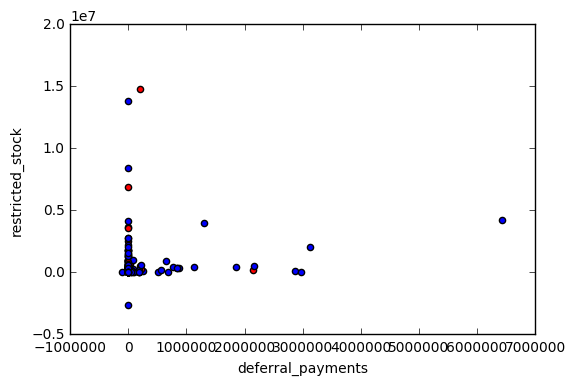

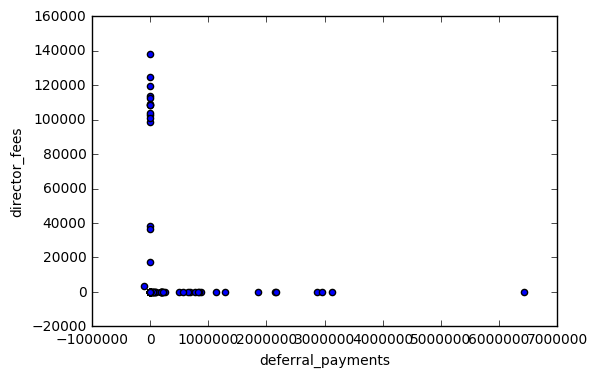

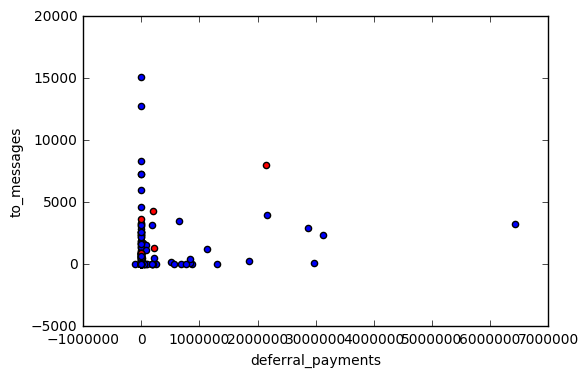

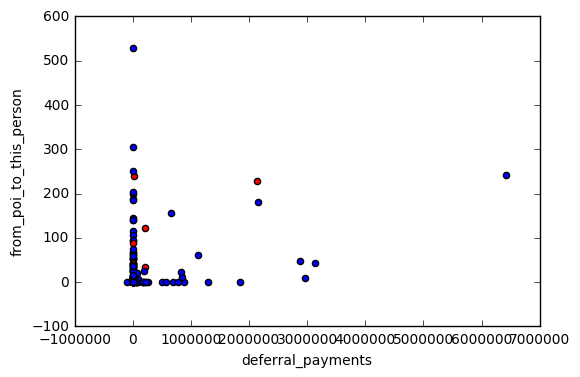

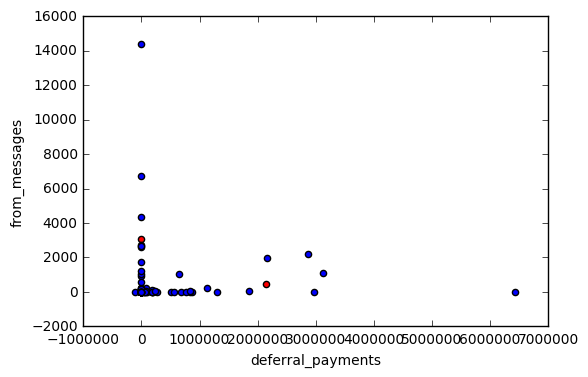

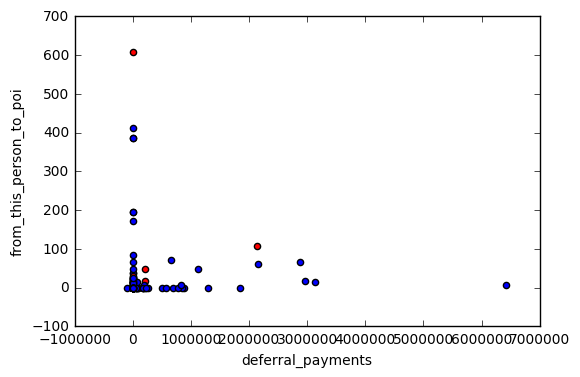

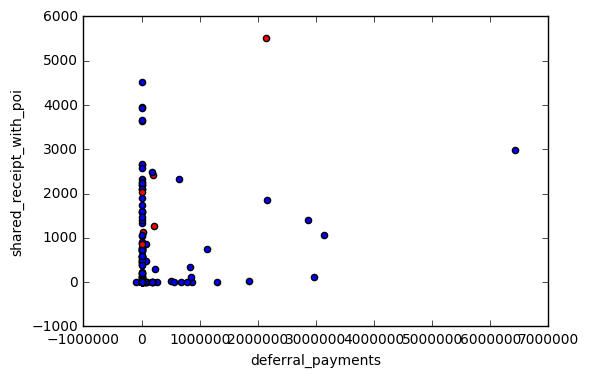

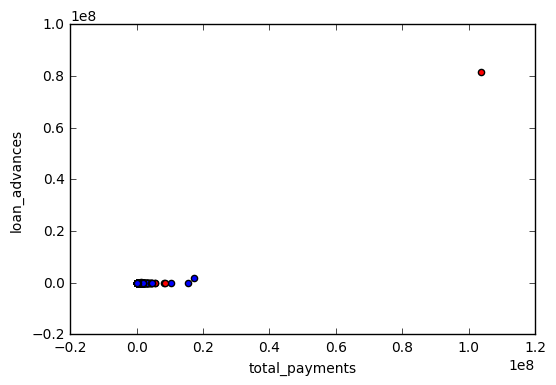

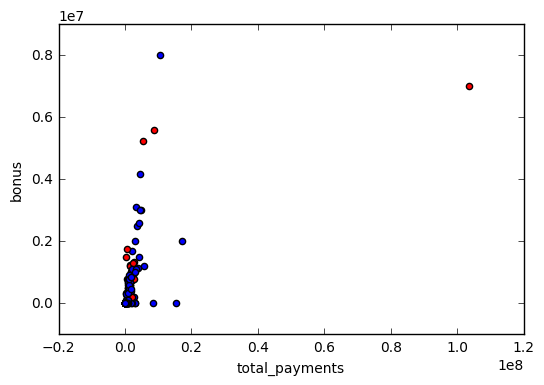

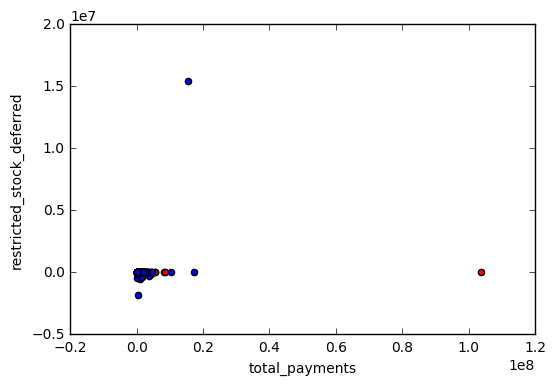

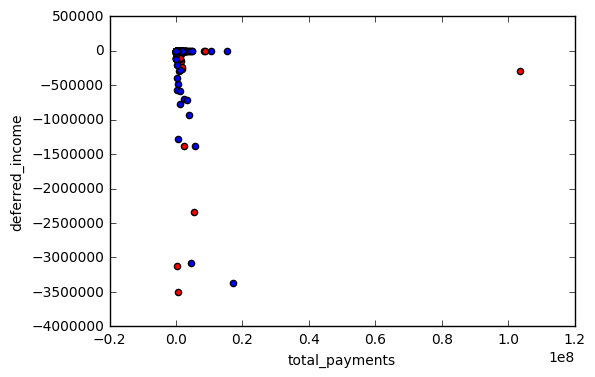

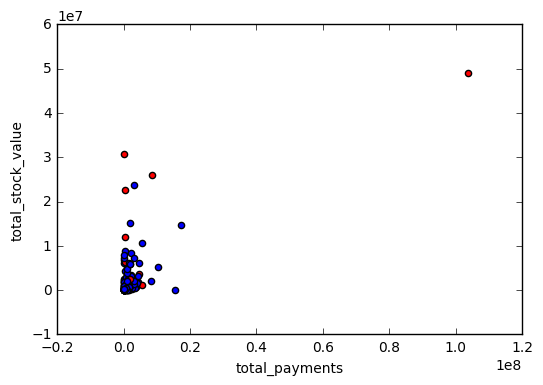

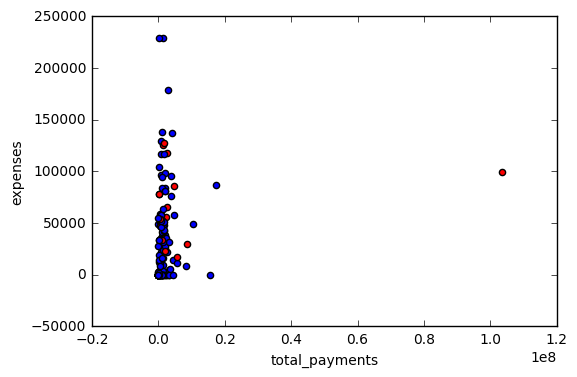

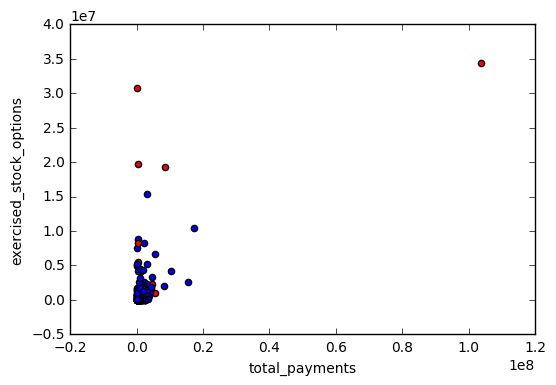

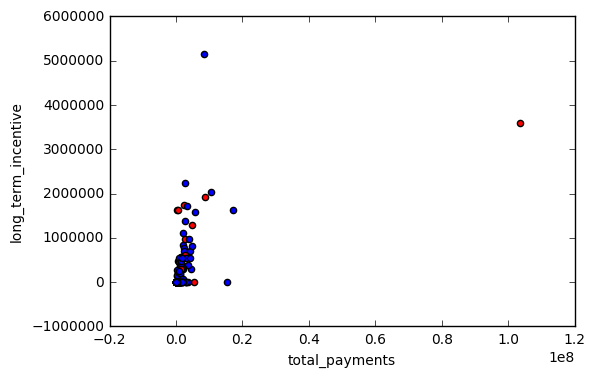

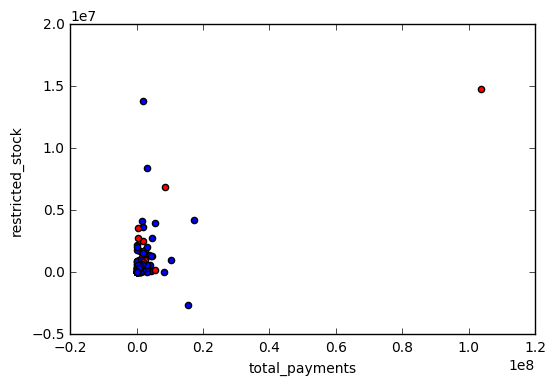

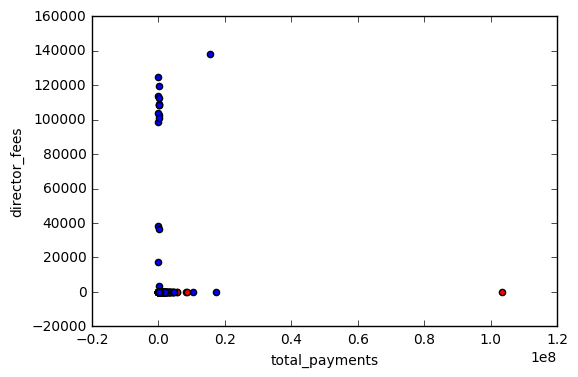

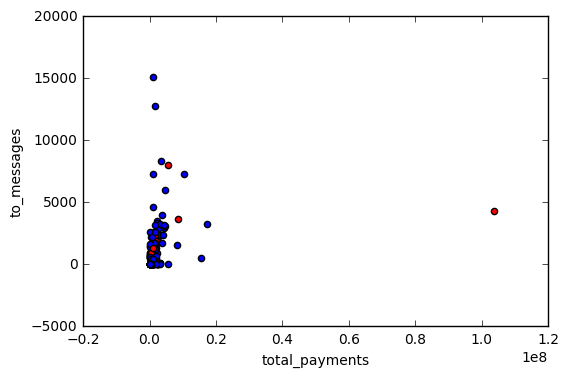

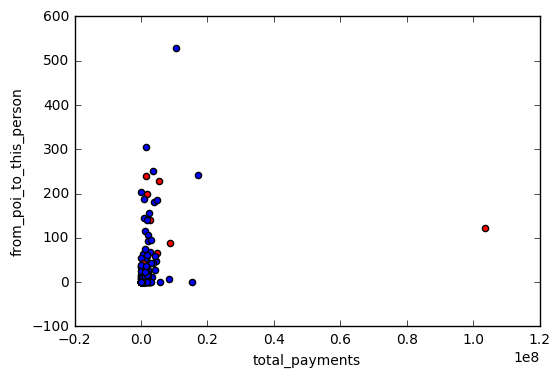

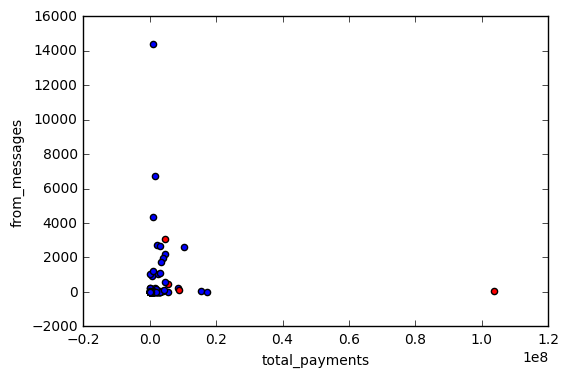

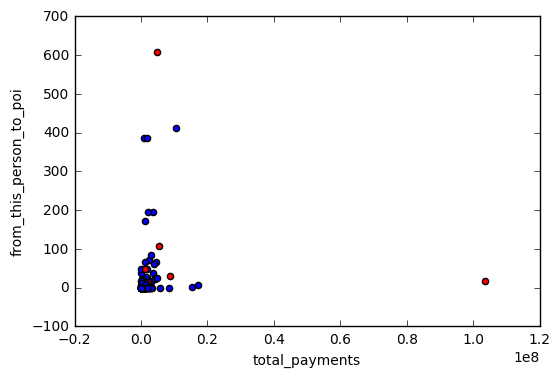

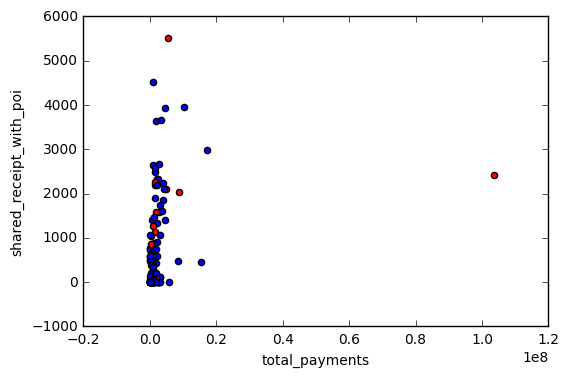

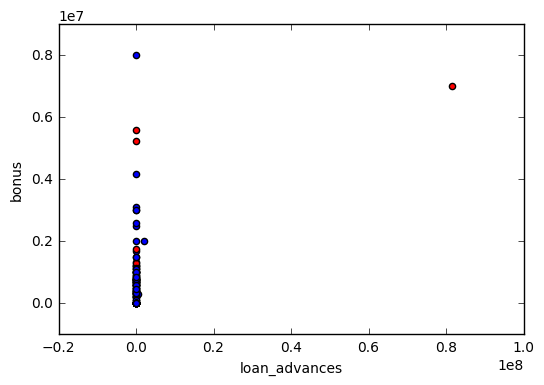

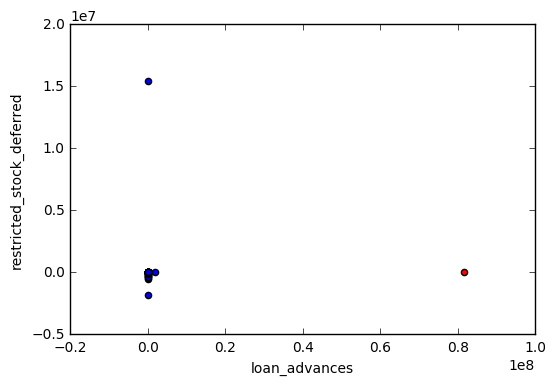

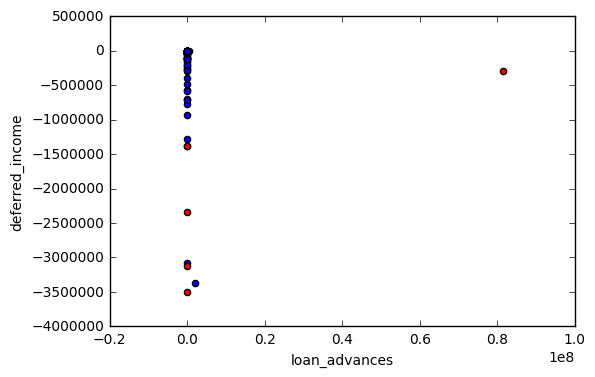

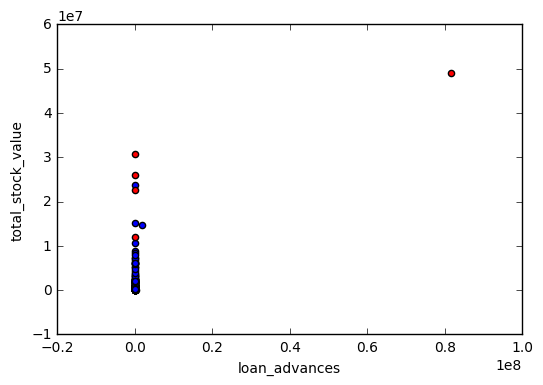

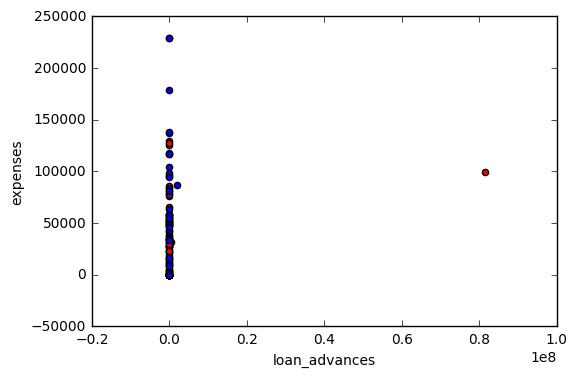

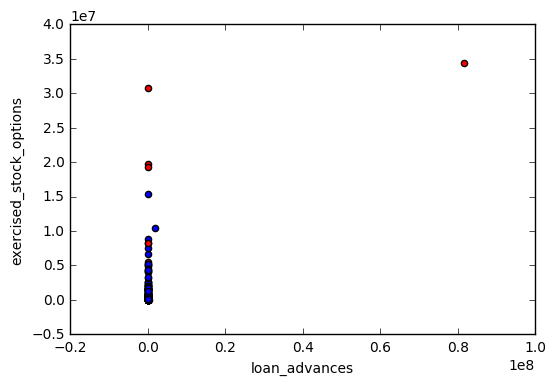

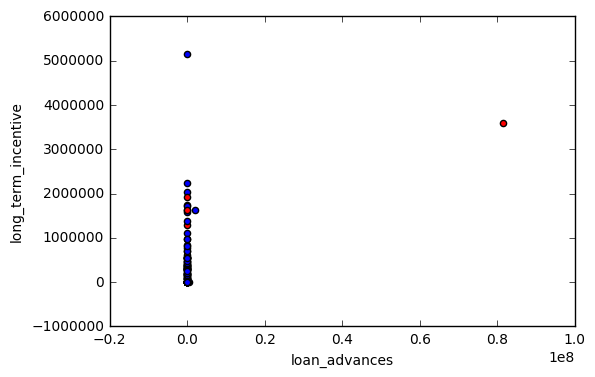

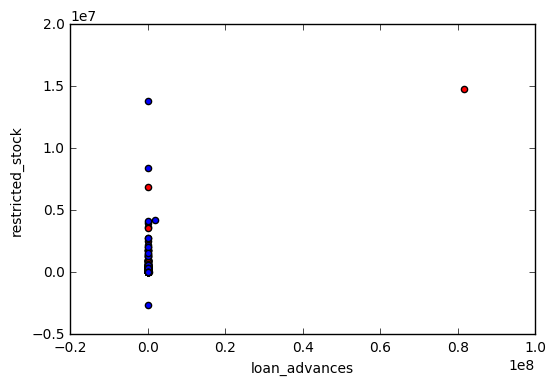

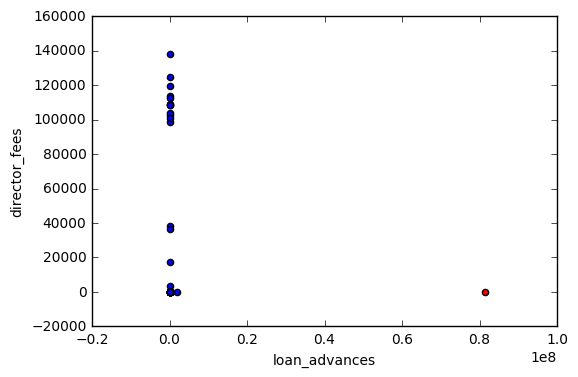

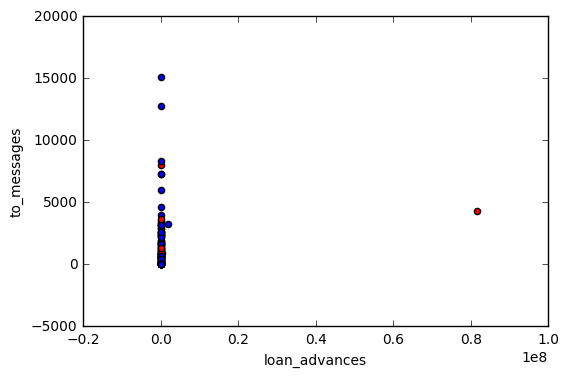

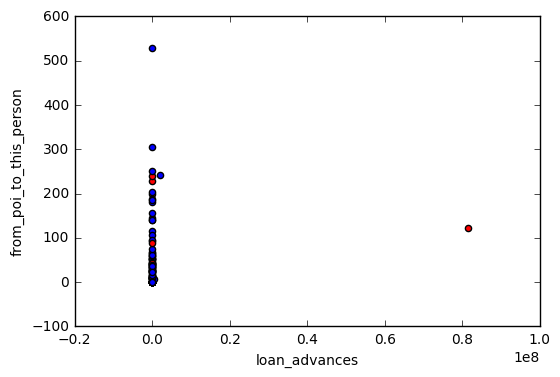

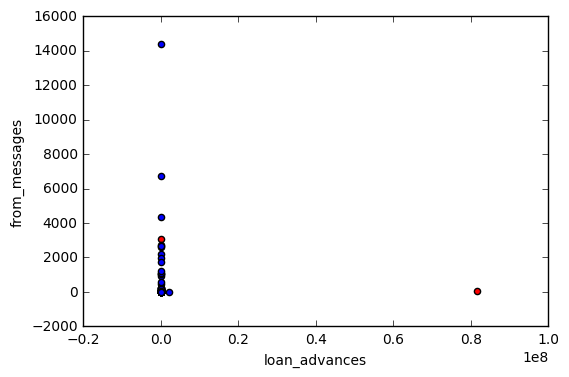

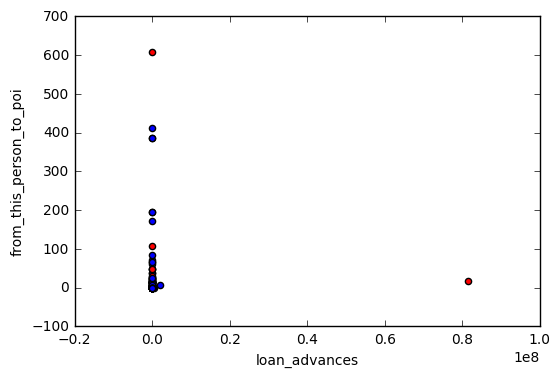

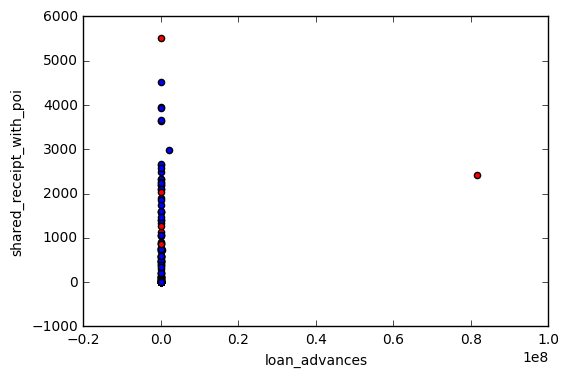

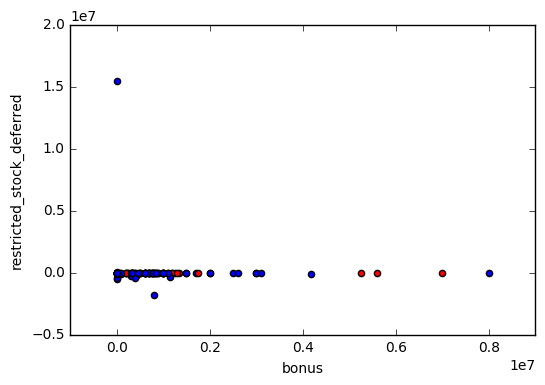

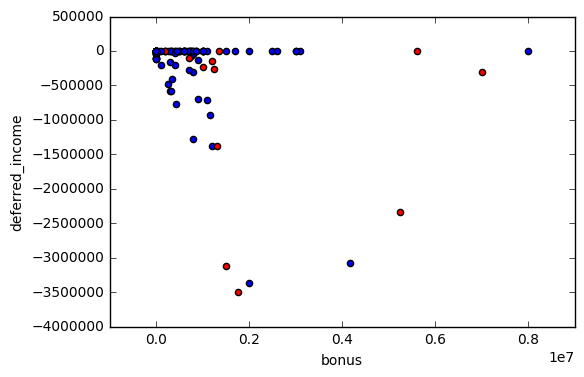

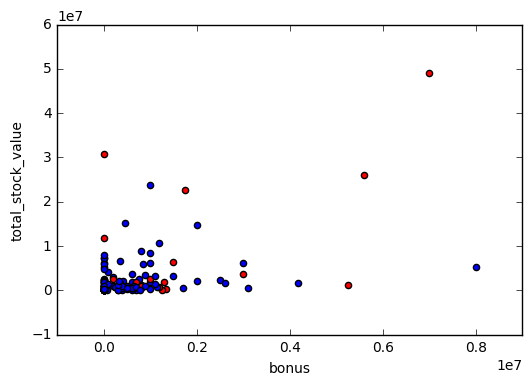

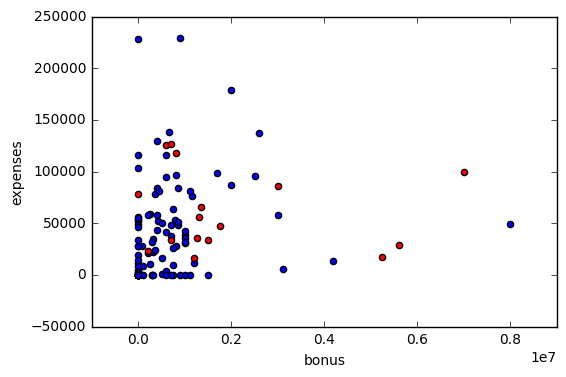

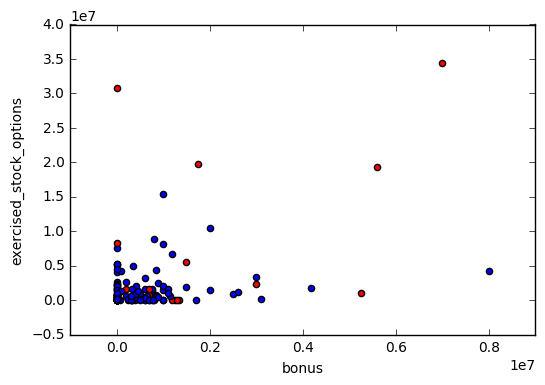

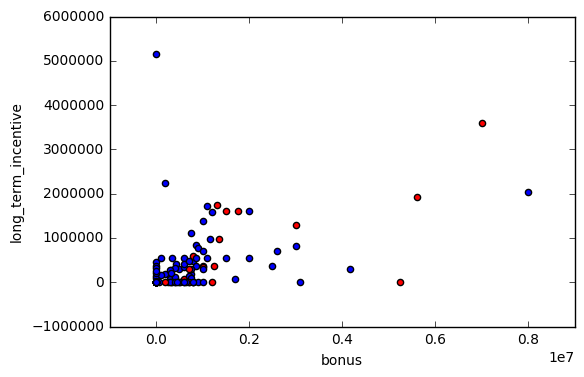

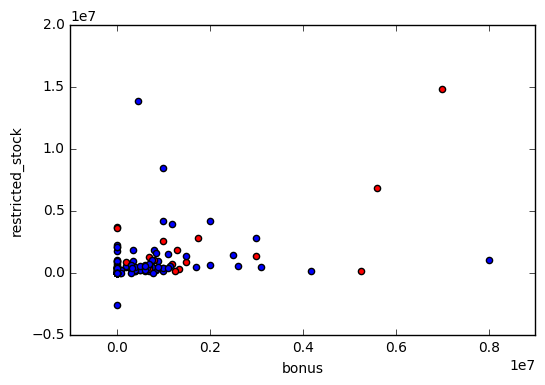

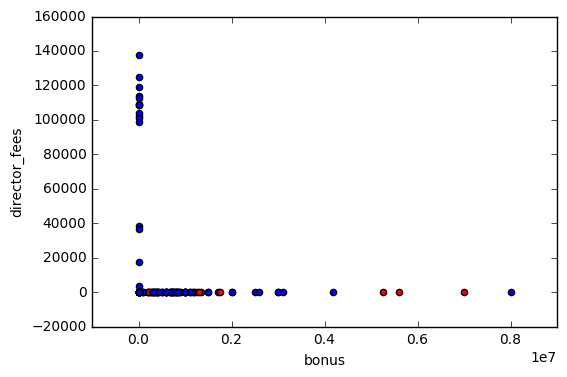

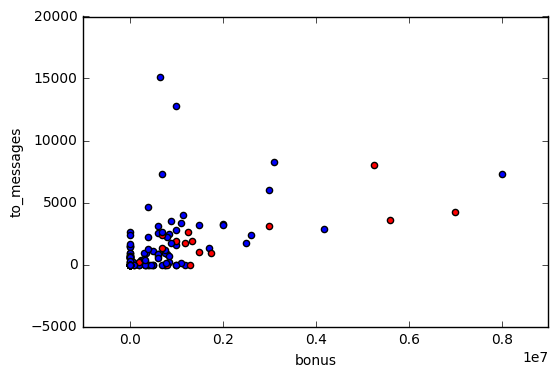

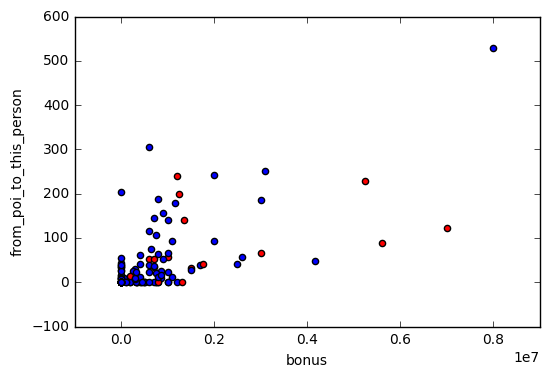

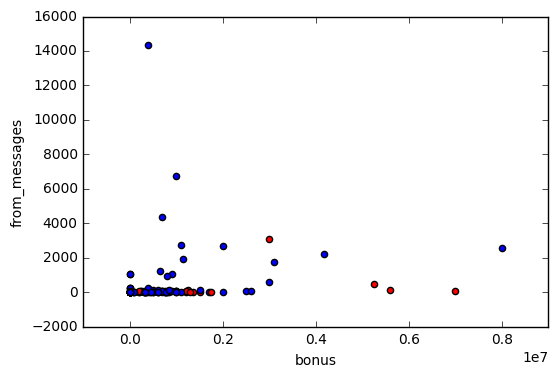

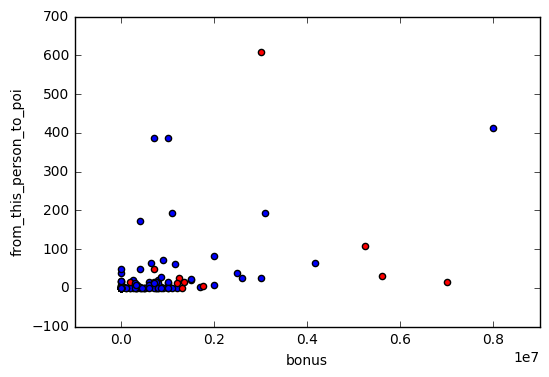

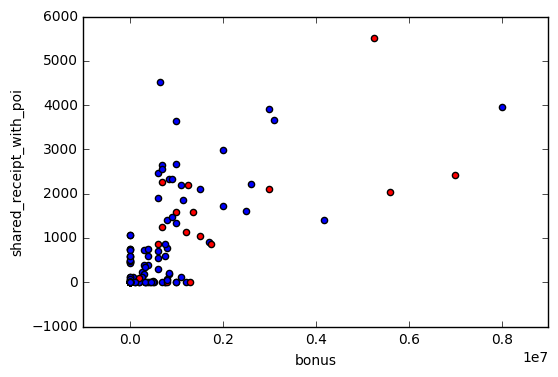

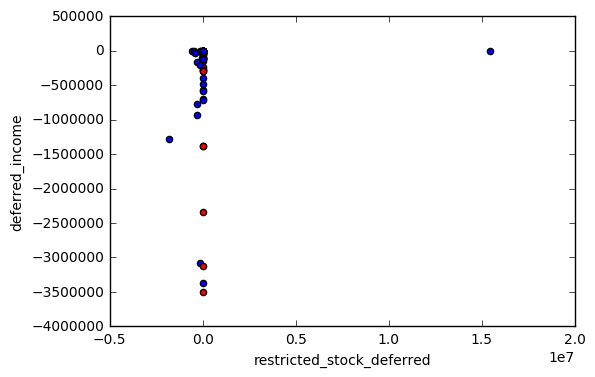

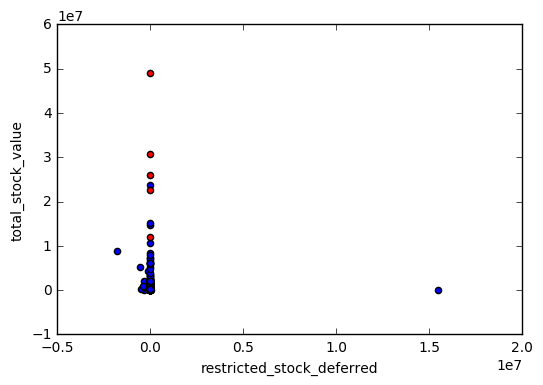

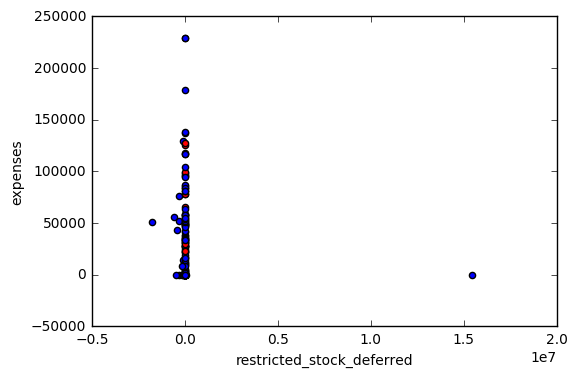

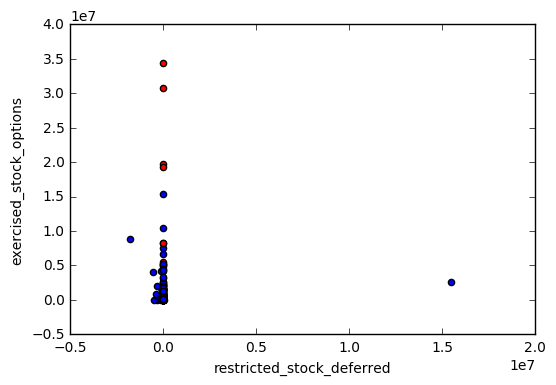

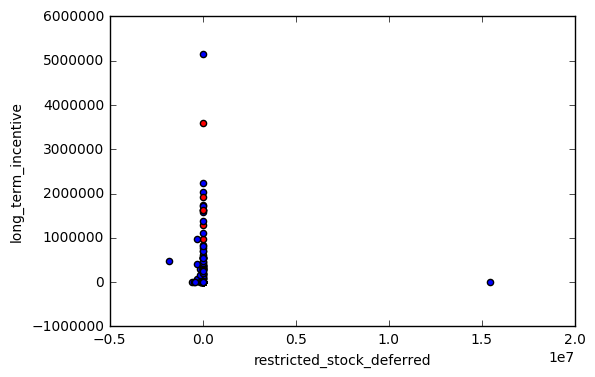

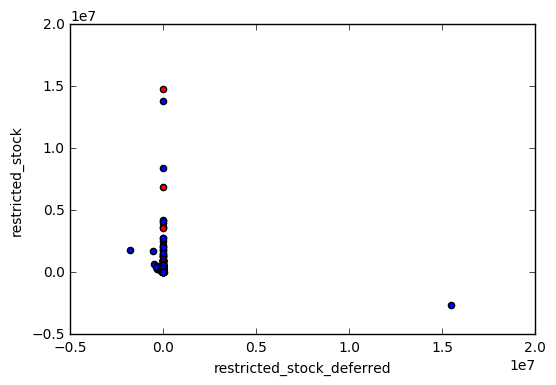

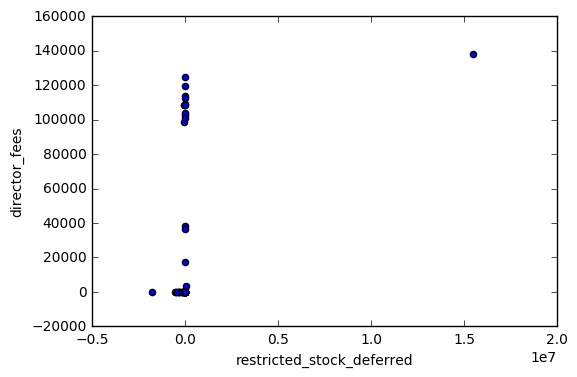

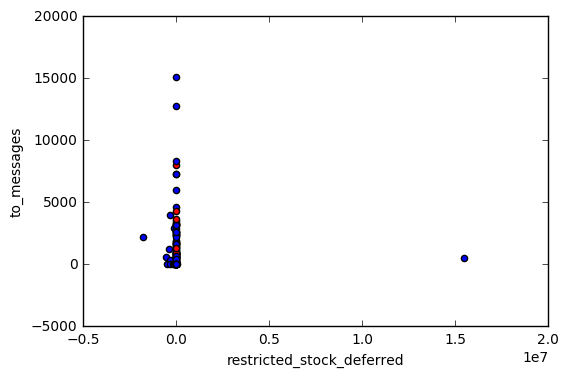

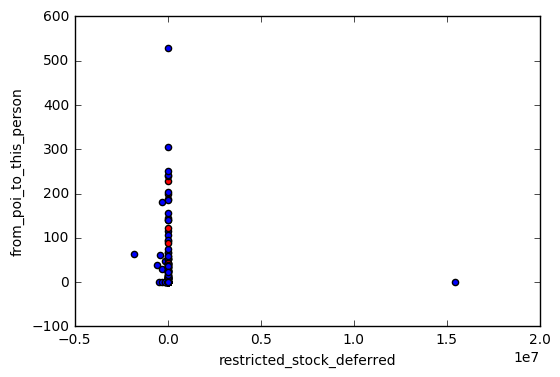

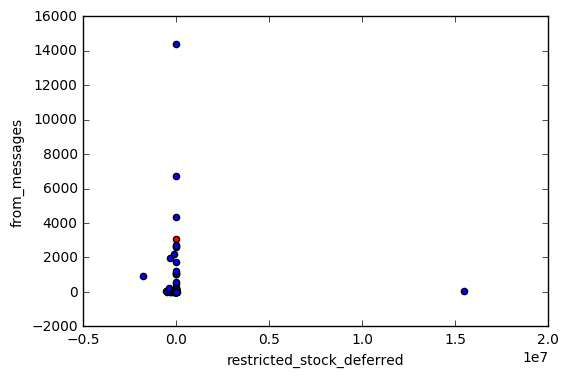

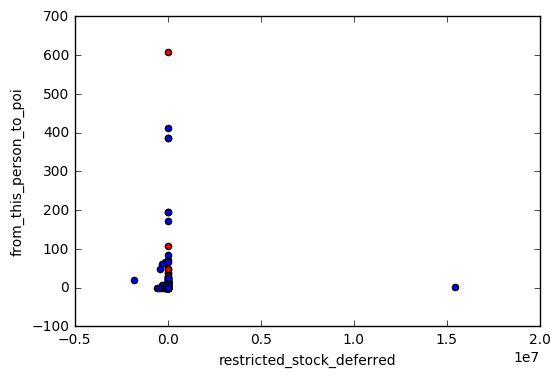

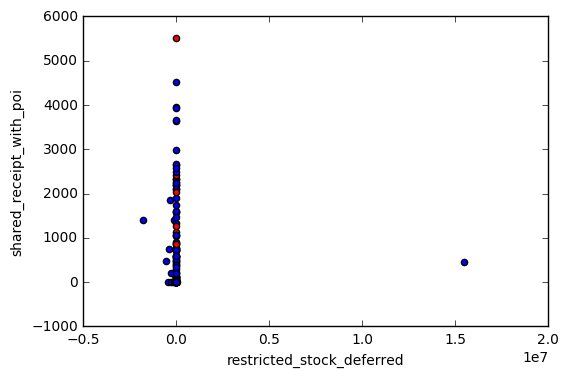

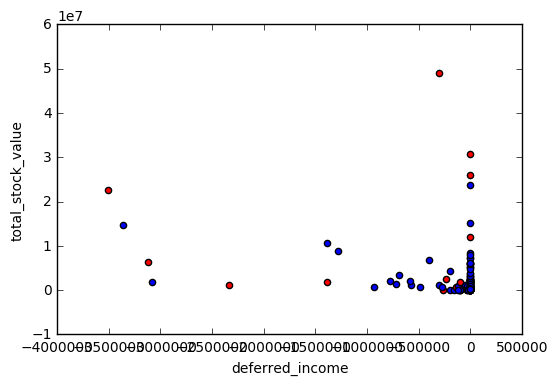

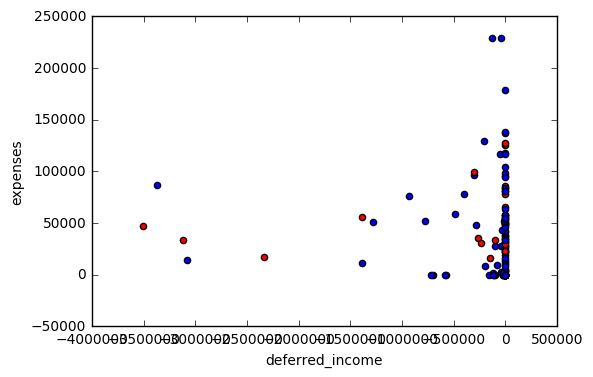

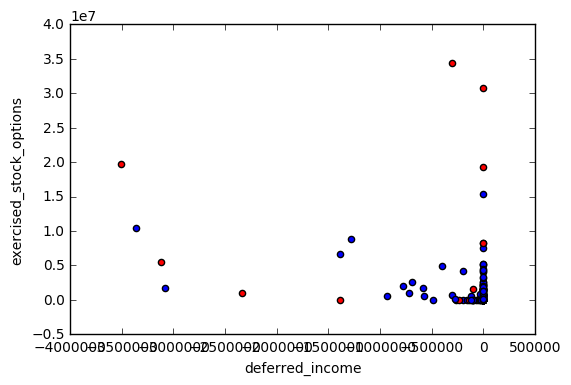

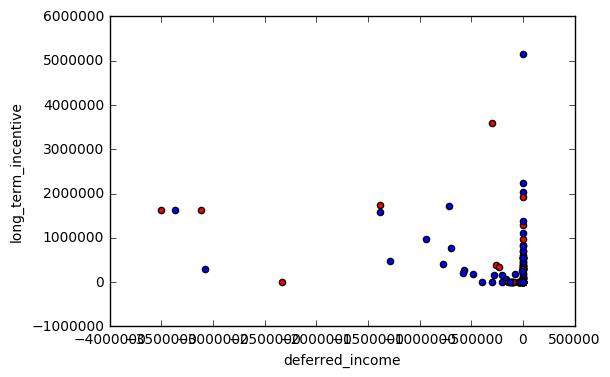

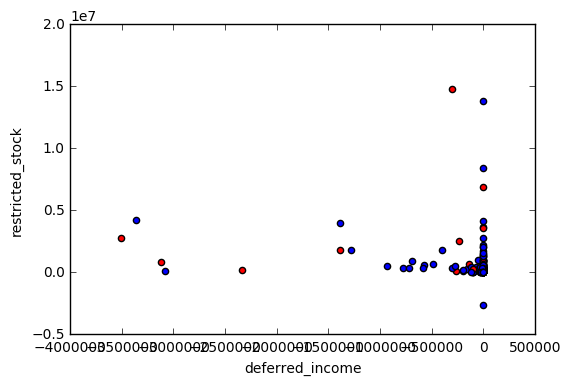

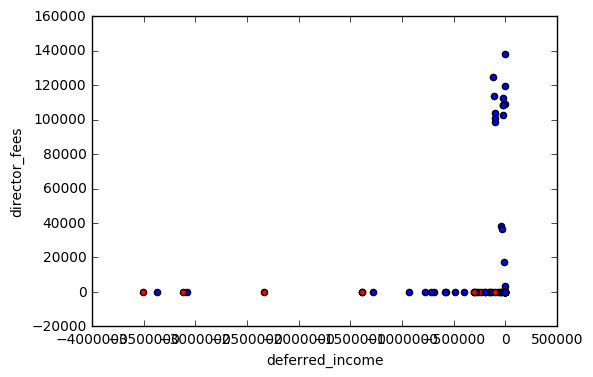

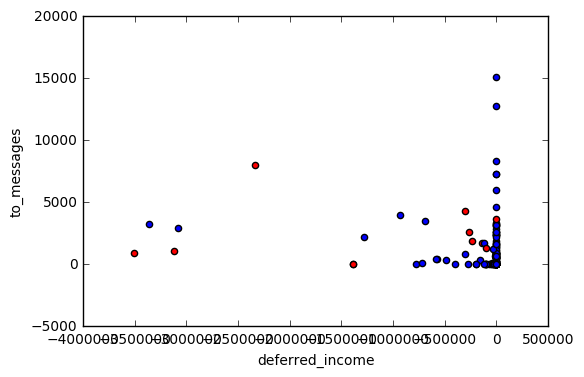

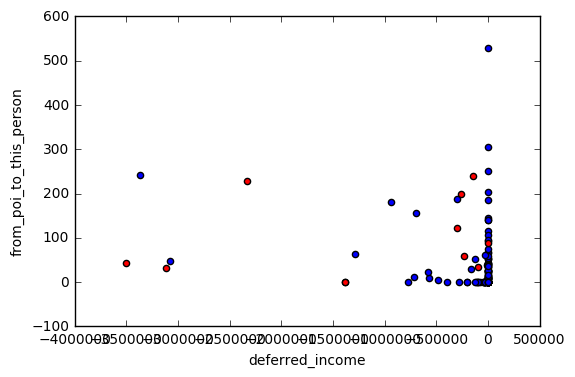

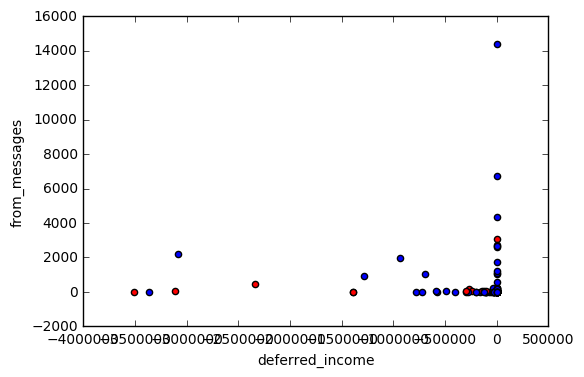

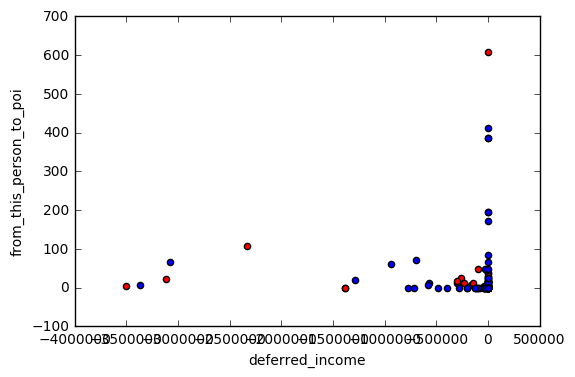

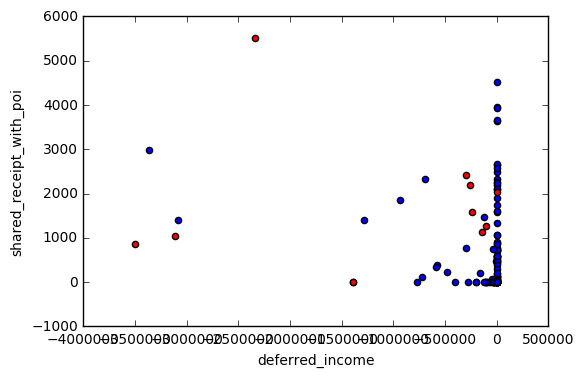

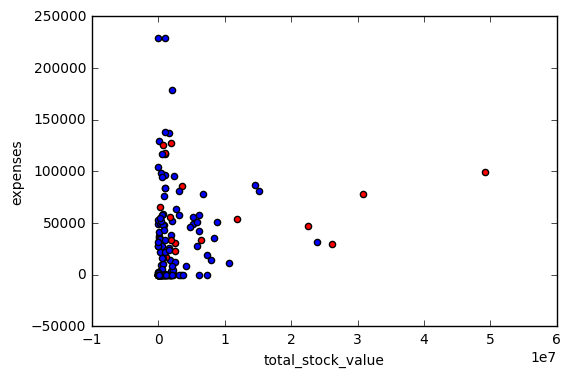

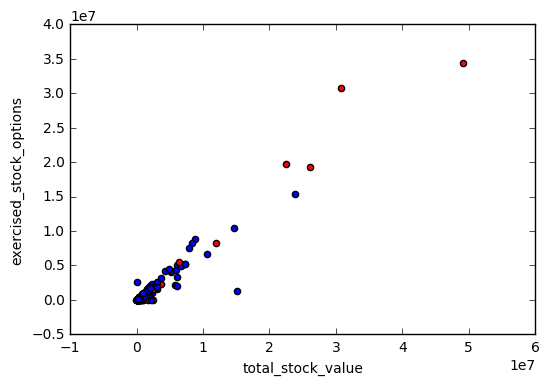

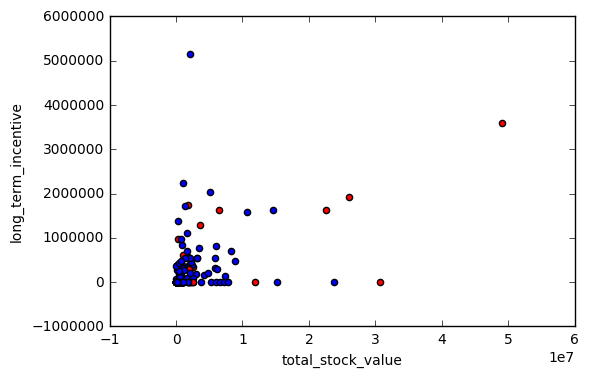

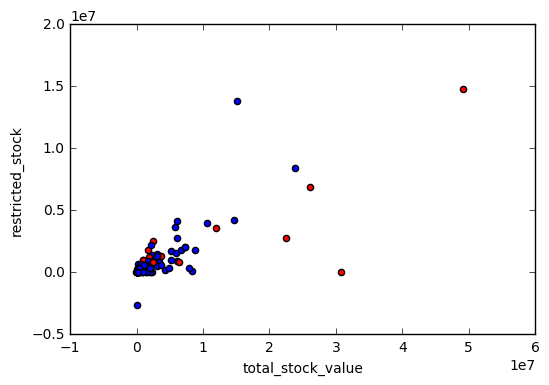

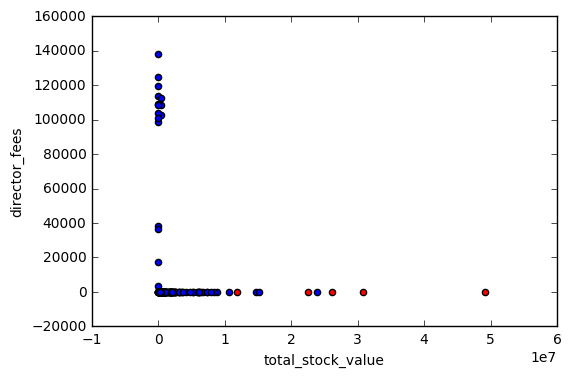

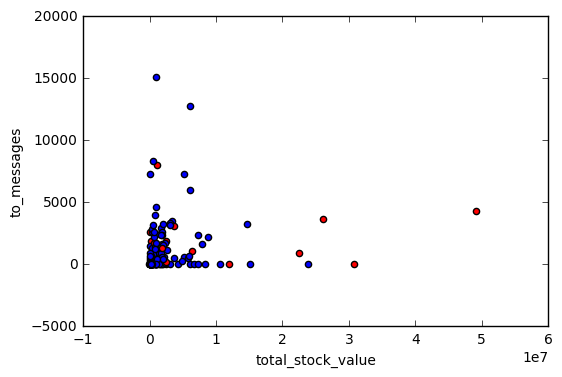

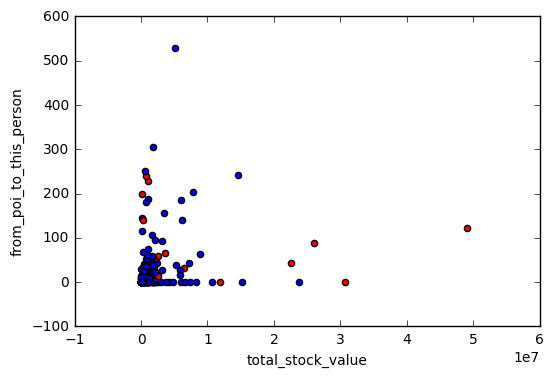

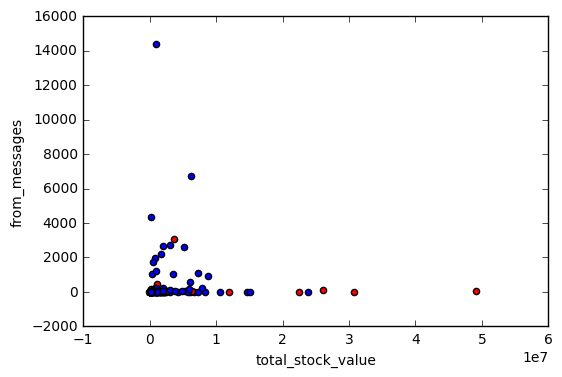

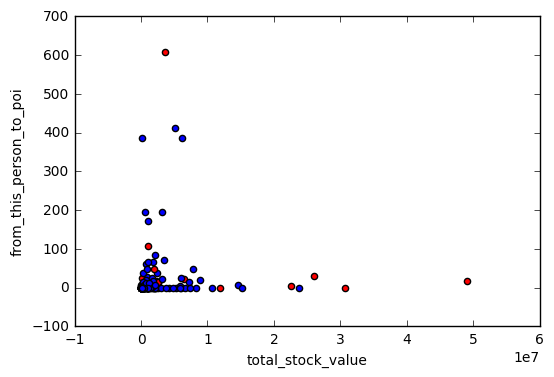

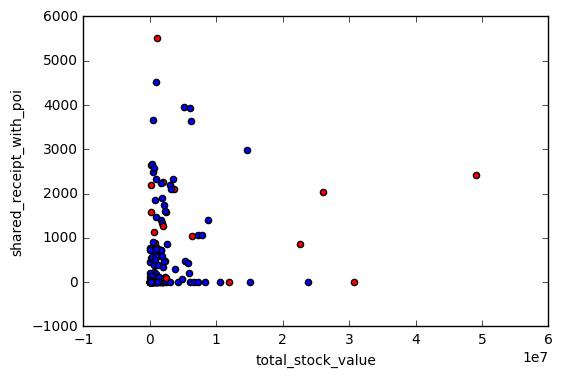

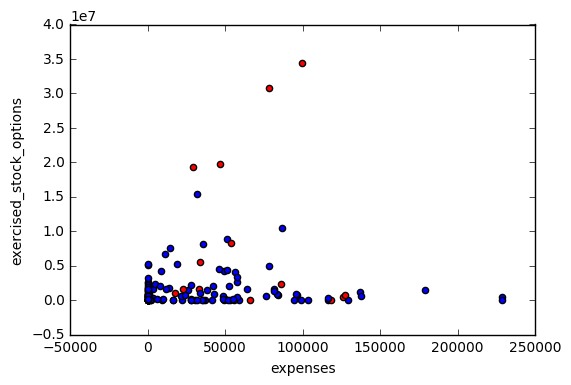

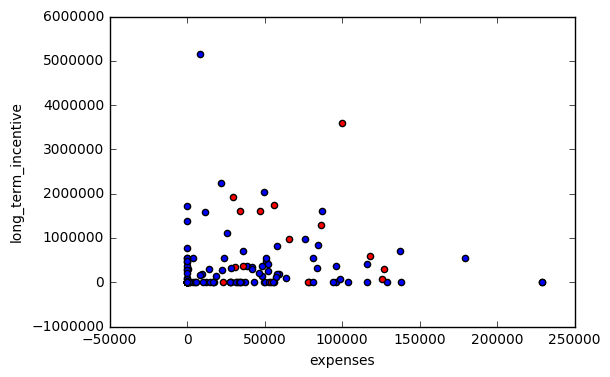

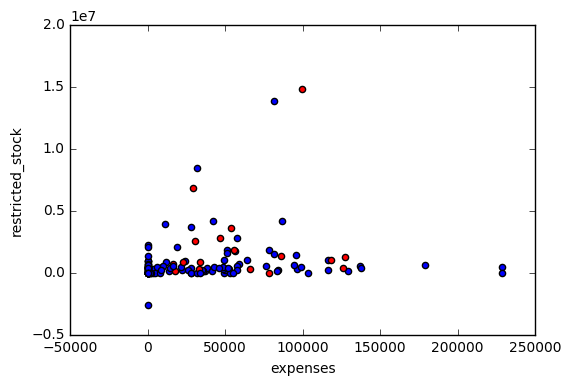

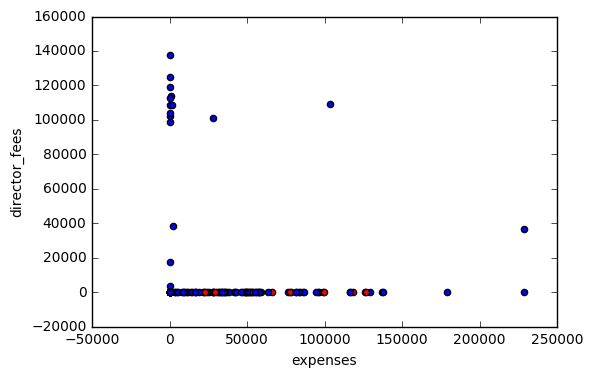

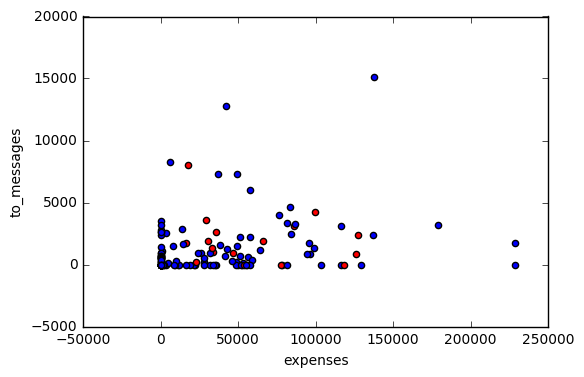

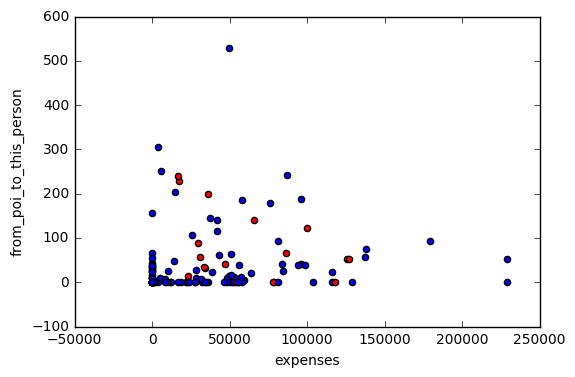

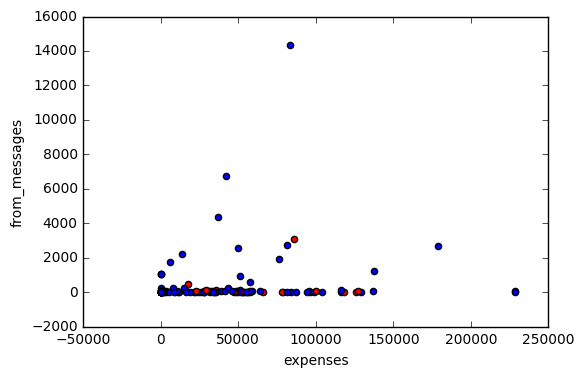

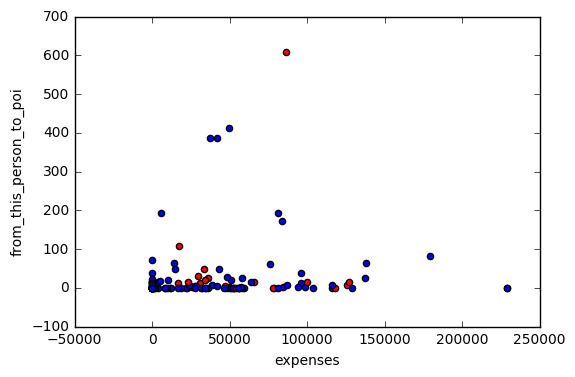

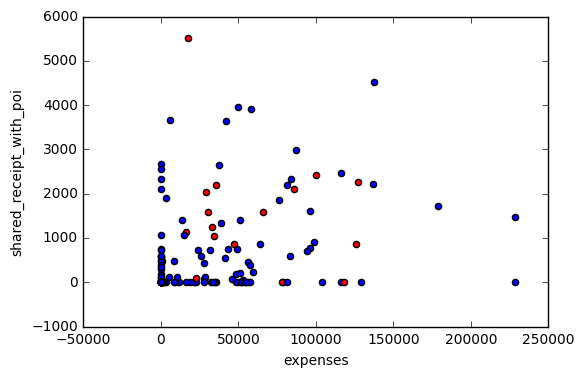

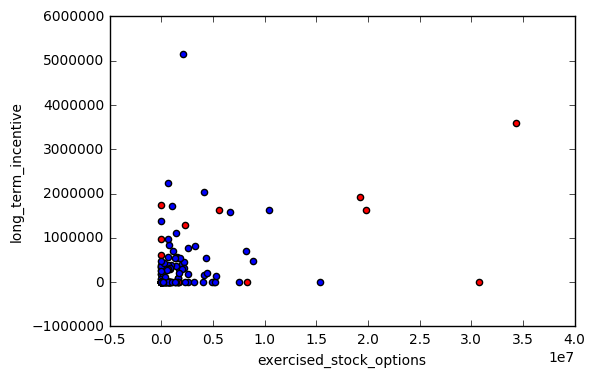

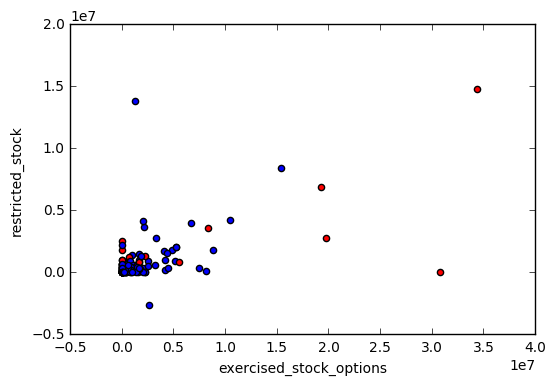

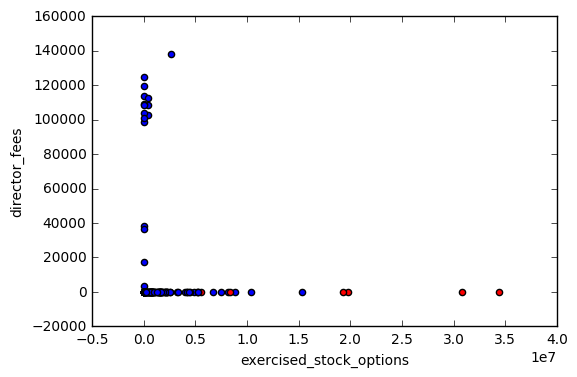

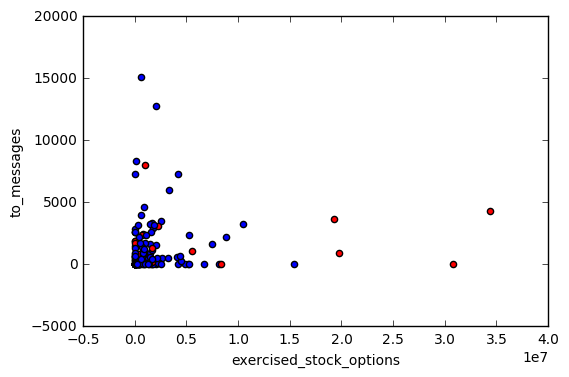

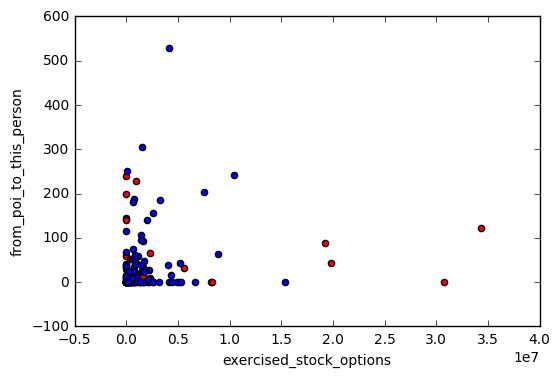

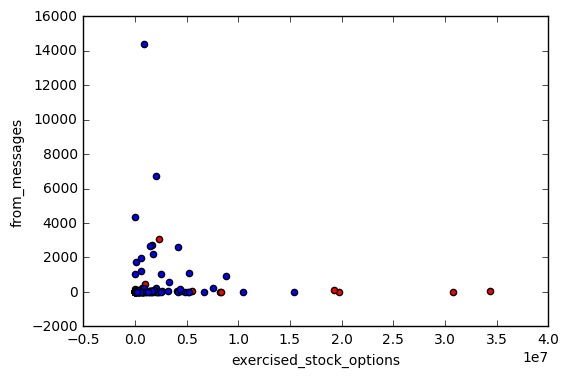

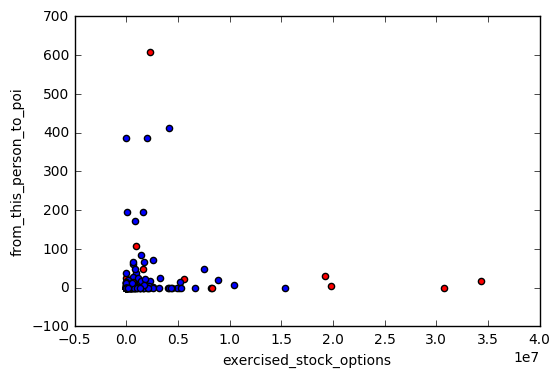

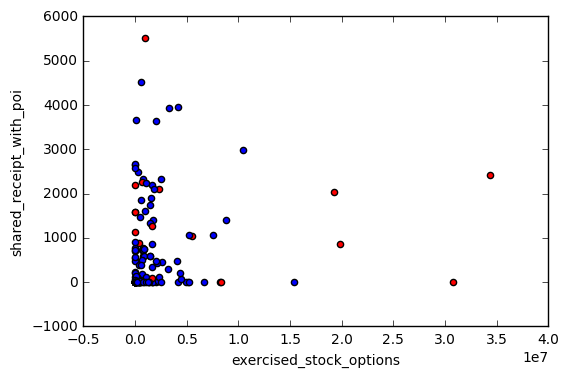

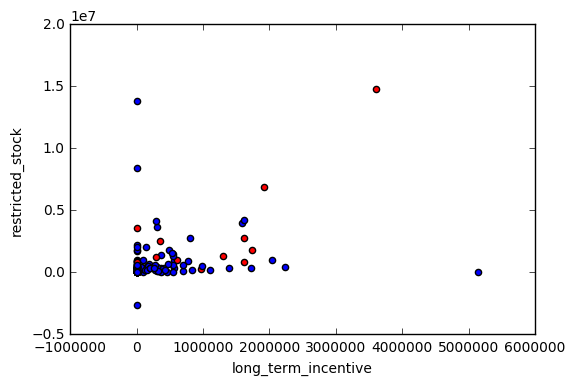

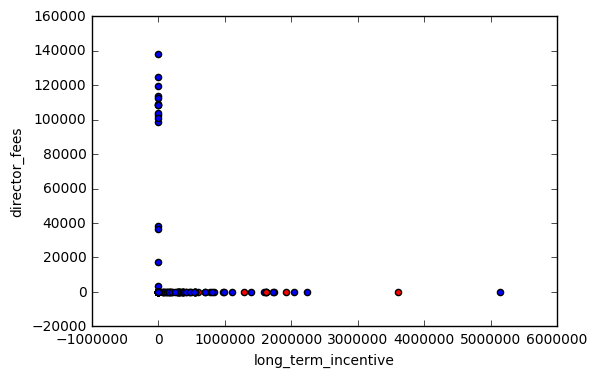

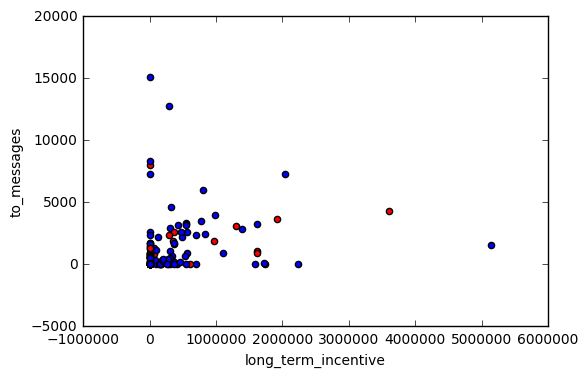

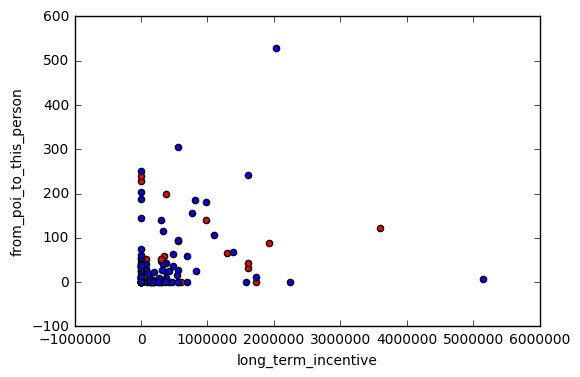

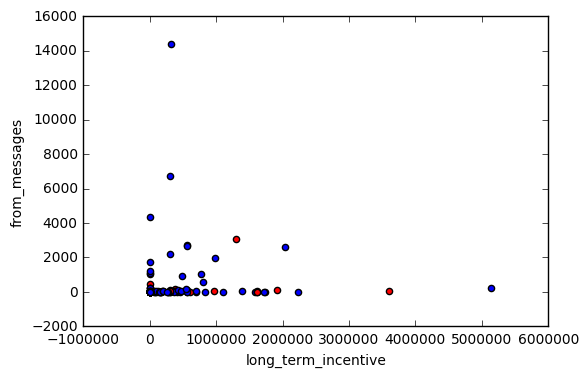

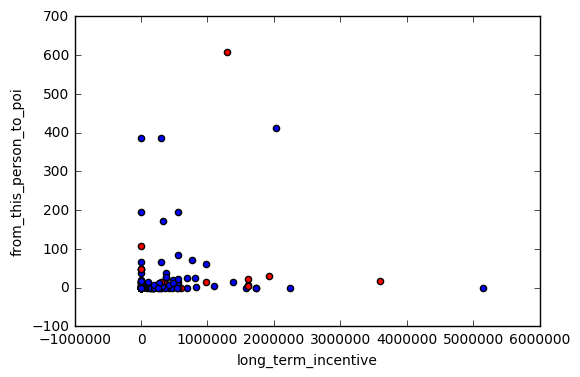

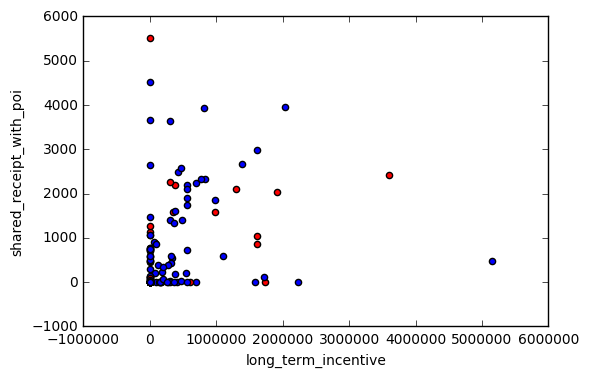

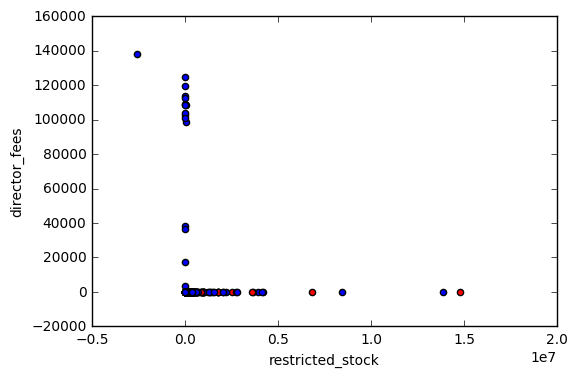

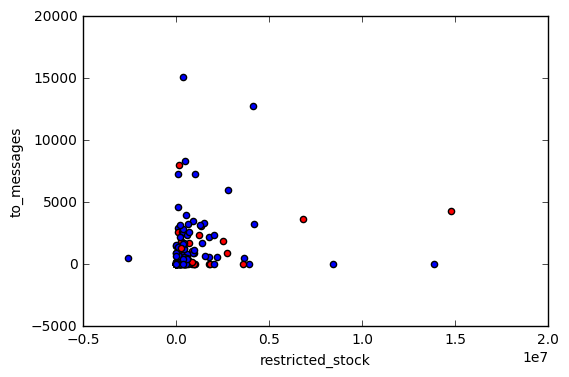

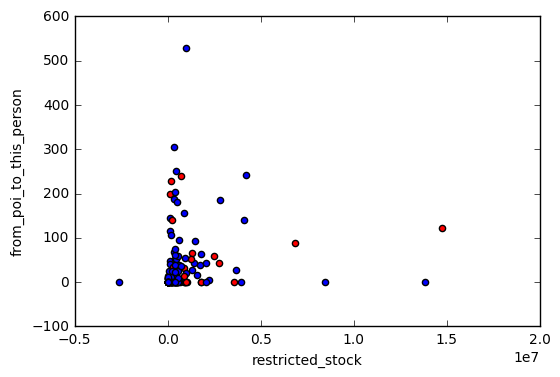

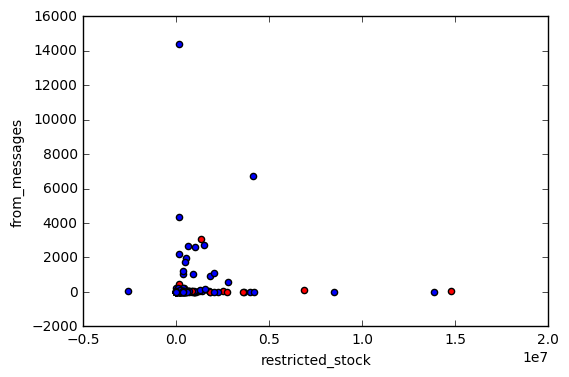

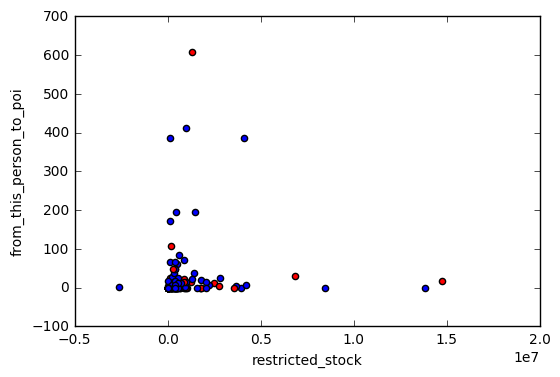

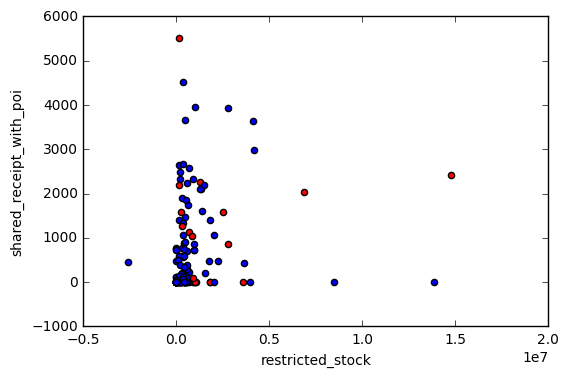

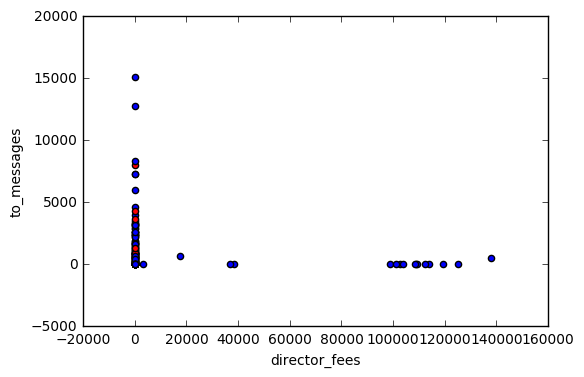

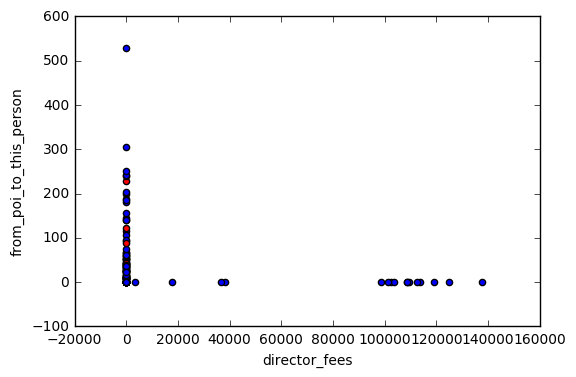

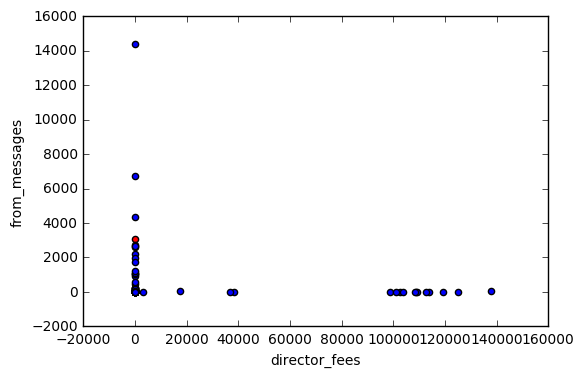

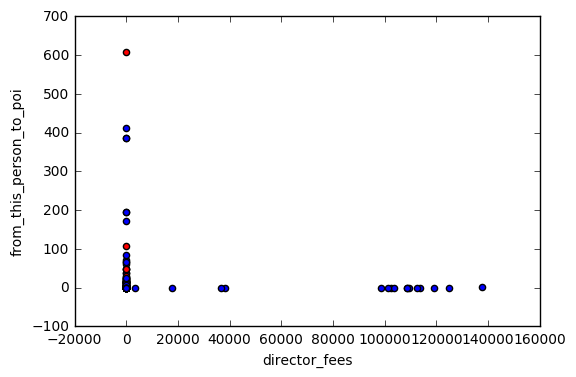

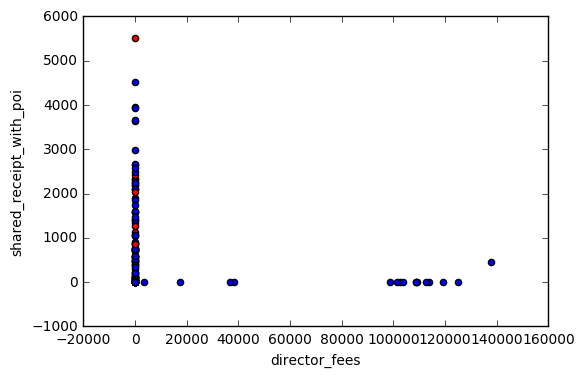

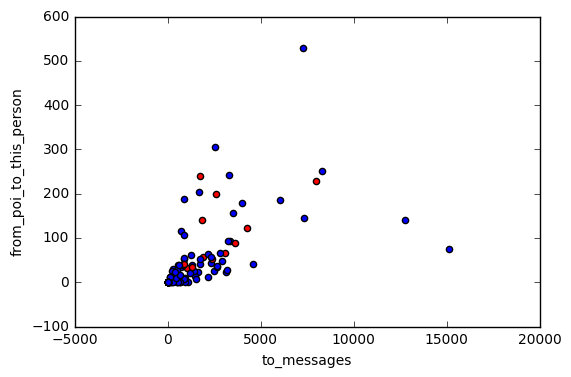

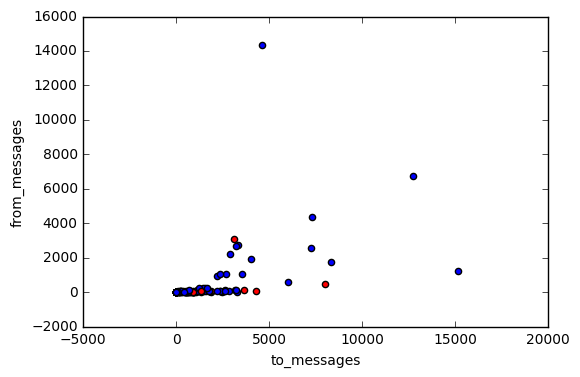

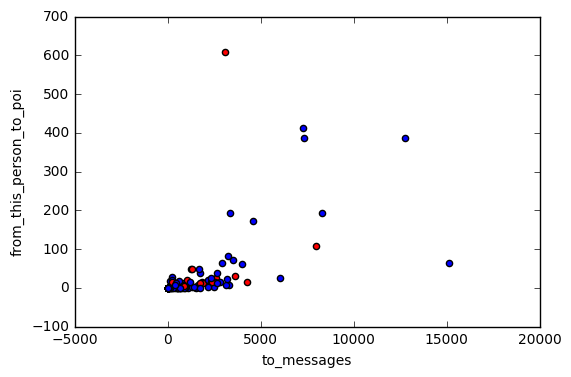

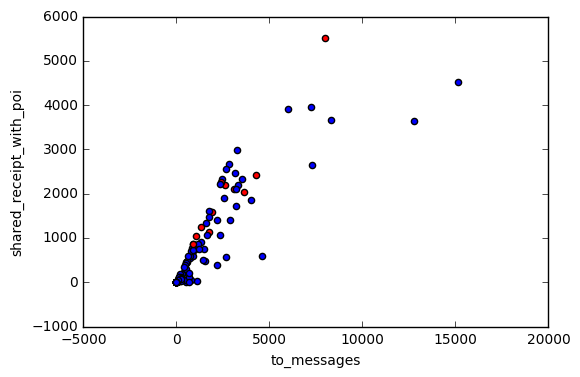

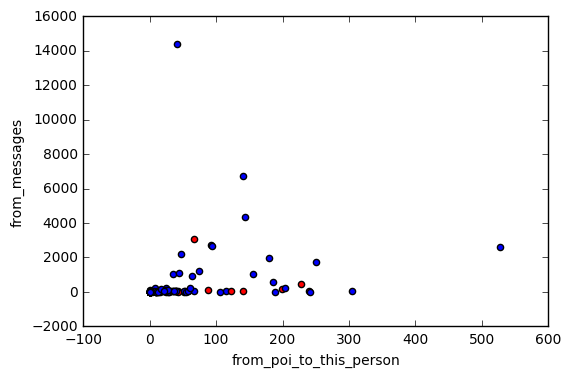

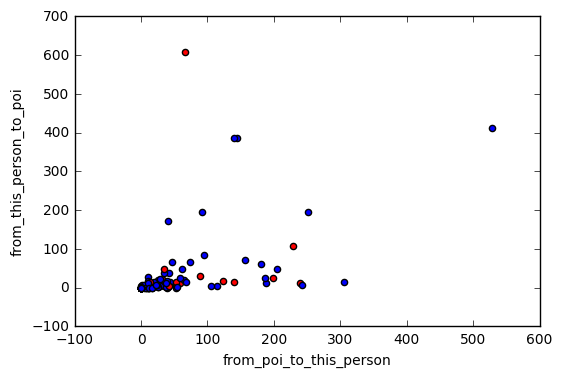

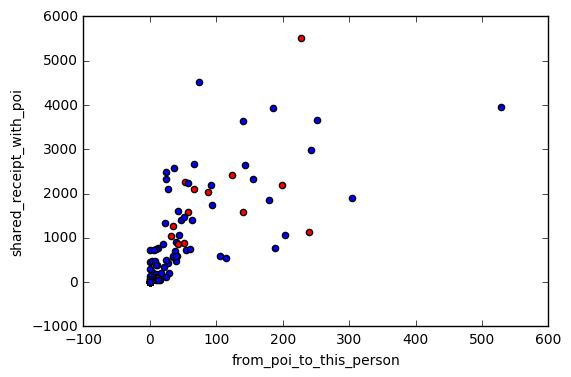

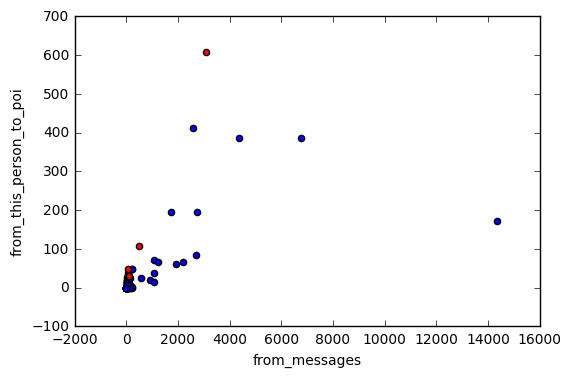

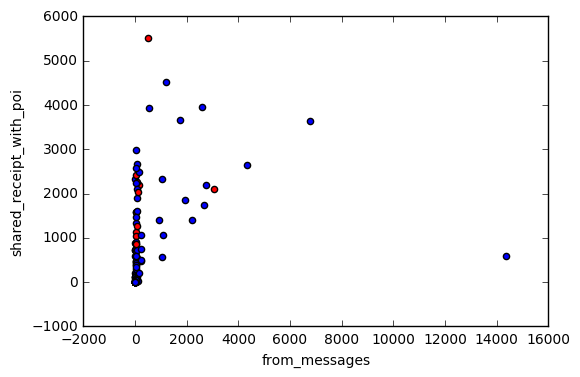

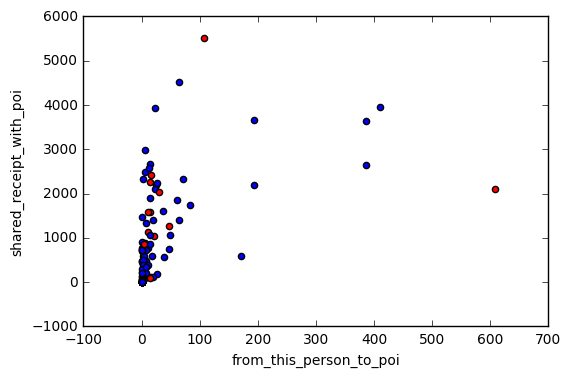

In [57]:
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Get feel of features to check outliers
import matplotlib.pyplot
for i in range(0,len(features_list)):
    for j in range(0,len(features_list)):
        if j>i:
            for point in data:
                if point[0]==0:
                    matplotlib.pyplot.scatter( point[i], point[j],c='b' )
                if point[0]==1:
                    matplotlib.pyplot.scatter(point[i],point[j],c='r')
            matplotlib.pyplot.xlabel(features_list[i])
            matplotlib.pyplot.ylabel(features_list[j])
            matplotlib.pyplot.show()

In [4]:
# current2=0

# for key in data_dict.keys():  
#     if data_dict[key]['total_payments']>current and data_dict[key]['total_payments']!='NaN':
#         outlier2=key
#         current2=data_dict[key]['total_payments']
    
# print outlier2,current2
# del data_dict[outlier2]

In [83]:
missing_values = dict()

for i in range(0,len(features_list)):
    missing_values[features_list[i]]=0
    for key in data_dict.keys():
        if data_dict[key][features_list[i]]=='NaN':
            missing_values[features_list[i]]+=1
            
print missing_values
print len(data_dict)
#print data_dict[outlier]

{'salary': 51, 'to_messages': 59, 'deferral_payments': 107, 'total_payments': 21, 'bonus': 64, 'director_fees': 129, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'expenses': 51, 'from_poi_to_this_person': 59, 'exercised_stock_options': 44, 'from_messages': 59, 'from_this_person_to_poi': 59, 'poi': 0, 'deferred_income': 97, 'shared_receipt_with_poi': 59, 'restricted_stock': 36, 'long_term_incentive': 80}
145


In [30]:
## Task 3: Create new feature(s)

def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    
    if all_messages == 'NaN':
        return fraction
    
    if poi_messages == 'NaN':
        poi_messages = 0
    
    fraction = 1.0*poi_messages/all_messages
    
    return fraction

for k,v in data_dict.items(): 
    v['to_poi_frac']=computeFraction(v['from_this_person_to_poi'],v['to_messages'])
    v['from_poi_frac']=computeFraction(v['from_poi_to_this_person'],v['from_messages'])
    if v['to_messages']!='NaN' and v['from_messages']!='NaN':
        v['shared_recipient_frac']=computeFraction(v['shared_receipt_with_poi'],v['to_messages']+v['from_messages'])
    else:
        v['shared_recipient_frac']='NaN'
    print v 
    data_dict[k]=v

{'to_messages': 807, 'deferral_payments': 'NaN', 'expenses': 94299, 'poi': False, 'from_poi_frac': 1.3103448275862069, 'deferred_income': 'NaN', 'email_address': 'mark.metts@enron.com', 'long_term_incentive': 'NaN', 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 702, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'director_fees': 'NaN', 'bonus': 600000, 'shared_recipient_frac': 0.8397129186602871, 'total_stock_value': 585062, 'from_poi_to_this_person': 38, 'from_this_person_to_poi': 1, 'restricted_stock': 585062, 'salary': 365788, 'to_poi_frac': 0.0012391573729863693, 'total_payments': 1061827, 'exercised_stock_options': 'NaN'}
{'to_messages': 'NaN', 'deferral_payments': 1295738, 'expenses': 11200, 'poi': False, 'from_poi_frac': 0.0, 'deferred_income': -1386055, 'email_address': 'NaN', 'long_term_incentive': 1586055, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 2660303, 'direc

In [31]:
frac_features=['to_poi_frac','from_poi_frac','shared_recipient_frac']
features_list.extend(frac_features)
features_list.remove('from_this_person_to_poi')
features_list.remove('from_poi_to_this_person')
features_list.remove('from_messages')
features_list.remove('to_messages')
features_list.remove('shared_receipt_with_poi')
#features_list.remove('deferral_payments')
#features_list.remove('director_fees')
#features_list.remove('bonus')
#features_list.remove('deferred_income')
#features_list.remove('long_term_incentive')
#features_list.remove('salary')
#features_list.remove('total_payments')
features_list.remove('total_stock_value')
#features_list.remove('expenses')
features_list.remove('exercised_stock_options')
features_list.remove('restricted_stock')
print features_list
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

['poi', 'salary', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'expenses', 'long_term_incentive', 'director_fees', 'to_poi_frac', 'from_poi_frac', 'shared_recipient_frac']


In [131]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
#from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from feature_format import featureFormat, targetFeatureSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# labels, features = targetFeatureSplit(data)
# #cv = StratifiedShuffleSplit(labels, 1, random_state = 42)

parameters = {'learning_rate':[0.01, 0.1, 0.5, 1]}
model = AdaBoostClassifier(random_state=9, n_estimators=50)
# model = tree.DecisionTreeClassifier(random_state=1)
# # model = AdaBoostClassifier(random_state=9)
gs = GridSearchCV(model, parameters, verbose = 2, scoring='recall',
                    cv= StratifiedShuffleSplit(n_splits=100, random_state=9) ,n_jobs = 3)

#clf = GaussianNB()
#clf=tree.DecisionTreeClassifier(random_state = 1)
#clf=svm.SVC()

In [132]:
gs.fit(features, labels)
gs.best_params_

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    2.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:    7.9s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:   16.7s
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:   18.5s finished


{'learning_rate': 1}

In [133]:
gs.cv_results_

{'mean_fit_time': array([ 0.13682   ,  0.11912999,  0.11841999,  0.11819   ]),
 'mean_score_time': array([ 0.00395   ,  0.00395   ,  0.00372003,  0.00395998]),
 'mean_test_score': array([ 0.1  ,  0.18 ,  0.275,  0.3  ]),
 'mean_train_score': array([ 0.18125,  0.5625 ,  1.     ,  1.     ]),
 'param_learning_rate': masked_array(data = [0.01 0.1 0.5 1],
              mask = [False False False False],
        fill_value = ?),
 'params': ({'learning_rate': 0.01},
  {'learning_rate': 0.1},
  {'learning_rate': 0.5},
  {'learning_rate': 1}),
 'rank_test_score': array([4, 3, 2, 1]),
 'split0_test_score': array([ 0. ,  0. ,  0. ,  0.5]),
 'split0_train_score': array([ 0.1875,  0.5625,  1.    ,  1.    ]),
 'split10_test_score': array([ 0.,  0.,  0.,  0.]),
 'split10_train_score': array([ 0.1875,  0.5625,  1.    ,  1.    ]),
 'split11_test_score': array([ 0. ,  0.5,  0.5,  0.5]),
 'split11_train_score': array([ 0.25  ,  0.5625,  1.    ,  1.    ]),
 'split12_test_score': array([ 0.,  0.,  0.,  0.])

In [32]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#clf = RandomForestClassifier(n_estimators=10, random_state=1, verbose=0)
#clf = GaussianNB()
# clf = tree.DecisionTreeClassifier()
clf = AdaBoostClassifier(random_state=7, n_estimators=75)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

iteration = 0
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

    clf.fit(features_train, labels_train)

    predictions = clf.predict(features_test)

    for prediction, truth in zip(predictions, labels_test):
        if prediction == 0 and truth == 0:
            true_negatives += 1
        elif prediction == 0 and truth == 1:
            false_negatives += 1
        elif prediction == 1 and truth == 0:
            false_positives += 1
        elif prediction == 1 and truth == 1:
            true_positives += 1
        else:
            print "Evaluating performance for processed predictions:"
            break
#     iteration += 1
#     if iteration%100==0:
#         print "Iteration {}/1000".format(iteration)
#         print(labels_test)
    
try:
    print true_negatives, false_negatives, false_positives, true_positives
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives)
    recall = 1.0*true_positives/(true_positives+false_negatives)
    print accuracy,precision,recall
except:
    print "Got a divide by zero when trying out:", clf
    print "Precision or recall may be undefined due to a lack of true positive predicitons."

11059 1487 941 513
0.826571428571 0.352819807428 0.2565


In [6]:
print features_list
clf.feature_importances_ 


['poi', 'salary', 'deferral_payments', 'total_payments', 'bonus', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'to_poi_frac', 'from_poi_frac', 'shared_recipient_frac']


array([ 0.12      ,  0.01333333,  0.06666667,  0.05333333,  0.06666667,
        0.12      ,  0.12      ,  0.14666667,  0.02666667,  0.13333333,
        0.08      ,  0.02666667,  0.02666667])

In [7]:
importances = clf.feature_importances_
for index, item in enumerate(importances):
    if item > 0.2:        
        print index,features_list[index], item       
       
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(10):
    print "{} feature no.{} ({})".format(i+1,indices[i],importances[indices[i]])


Feature Ranking: 
1 feature no.7 (0.146666666667)
2 feature no.9 (0.133333333333)
3 feature no.6 (0.12)
4 feature no.5 (0.12)
5 feature no.0 (0.12)
6 feature no.10 (0.08)
7 feature no.4 (0.0666666666667)
8 feature no.2 (0.0666666666667)
9 feature no.3 (0.0533333333333)
10 feature no.12 (0.0266666666667)


1.
The goal of this project is to be able to create a machine learning classificiation model using selected financial and email features that is able to identify the person of interest that is involved in the Enrol fraud scandal.
The data set contains of 146 rows which consists of 145 people and 1 row summing the total number for all the features. There are 18 POIs (Person of Interests) in the data set (around 12.4% of the whole data). Person of interest is defined as someone who is involved in the fraud by being an accomplice or an actual perpetrator and is labeled as 1 in the data (0 is for innocent people working at Enron during that time). These numbers are actually on the low side for a typical machine learning task: we have very few data points and even fewer people who are labeled as the culprits. This task is also quite unique because we are not trying to predict future data but we are just trying to create an algorithm that is able to identify these POIs for us using past data that are avaiable for us.

First, I decided to count the number of NaNs for each feature and found out that there are a few features that has high number of NaNs (>70% of NaNs), which are: loan_advancements, deferral_payments, director_fees and restristed_stock_deferred.

``` python
#Check how many missing values we have per feature
missing_values = dict()

for i in range(0,len(features_list)):
    missing_values[features_list[i]]=0
    for key in data_dict.keys():
        if data_dict[key][features_list[i]]=='NaN':
            missing_values[features_list[i]]+=1
            
print missing_values
```

I decided to remove loan_advancements since we only have 4 data points for that feature but keep the rest as the absence of these features (meaning having 0 as a value) might be an indicator of being innocent (and since we have an imbalance ratio of POIs and non-POIs so NaN can be a good indicator). Also, I plotted the financial features against each other in order to get a sense of the data and there are some outliers especially for the stocks. 

``` python
### Get feel of features to check outliers
import matplotlib.pyplot
for i in range(1,len(features_list)):
    for j in range(1,len(features_list)):
        if j>i:
            for point in plot_data:
                if point[0]==0:
                    matplotlib.pyplot.scatter( point[i], point[j],c='b' )
                if point[0]==1:
                    matplotlib.pyplot.scatter(point[i],point[j],c='r')
            matplotlib.pyplot.xlabel(features_list[i])
            matplotlib.pyplot.ylabel(features_list[j])
            matplotlib.pyplot.show()
```

I decided to keep it because the fact of being an outlier financially can be a good indicator of being a culprit since they are actually the people who made a lot of money from this fraud and I have found that removing the outlier dropped my recall and precision score slightly.

2.
I ended up using: salary, deferral_payments, total_payments, bonus, deferred_income, total_stock_value, expenses, exercised_stock_options, long_term_incentive, restricted_stock, director_fees and 3 other features for email that I made which are basically fractions of email to/from POI over the total number to/from emails: to_poi_frac, from_poi_frac and shared_recepient_frac. I removed director_fees and restricted_stock_deferred because not only they have high number of missing values, the data that we have for those features are only for non-POIs, which I checked using this code:

``` python
#Create DataFrame with count of 0s and 1s for each feature with missing value
import pandas as pd

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

nans = pd.DataFrame(0, index=[0,1], columns=features_list[1:])
for i in range(len(features)):
    label = int(labels[i])
    for j in range(len(features[i])):
        if features[i][j] == 0.0:
            nans.iloc[label,j] += 1
        
nans.T
```

I created the fraction of email features as suggested from the tutorial videos and it makes more sense to reduce 5 features into 3 simpler features that gives a better estimate of the interaction of the person with POIs. I also removed other because I do not understand the meaning of the 'other' feature. I was also able to rank feature importances because I was using a decision tree classifier as the base estimator for my ADA Boost. From the ranking, my newly made features about email interaction with POIs are the least important. 

``` python
importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(10):
    print "{} feature no.{} ({})".format(i+1,indices[i],importances[indices[i]]) 
print features_list
```

But I still decided to keep them because it still helped with my recall and precision results. I did not scale my features because I used a decision tree classifier that does not require feature scaling unlike SVMs.


3.
After trying out different parameters mainly GaussianNB, RandomForest and AdaBoost, I have decided to use AdaBoost at the end. I found that GaussianNB to be not robust, by simply removing one feature, the resulting accuracy, precision and recall can be really different. Random Forests are much more robusts but results in overfitting. AdaBoost gave me the best results at the end.

``` python
#Past models tried
clf = GaussianNB()
clf=tree.DecisionTreeClassifier(random_state = 1)
clf=svm.SVC()
clf = RandomForestClassifier(n_estimators=10, random_state=1, verbose=0)
```


4.
I initially tuned the parameters of Random Forest but after using GridSearchCV to test out n_estimators as well as max depth, I got really high scores for my train_set but really low results for my test_set. This implies that I have a problem with overfitting when using random forests. Then, I used ADA Boost with DecisionTreeClassifier as the base estimators. Again using GridSearchCV with n_estimators and learning rate, I found that learning rate of 1 is the optimal and by increasing the n_estimators above 50, I was able to achieve past the minimum requirement of 0.3 recall and precision but there is a tradeoff with the time of fitting and predicting if I use a higher number of estimators. 

``` python
#GridSearchCV for AdaBoostClassfier
parameters = {'learning_rate':[0.01, 0.1, 0.5, 1],'n_estimators':[25,50,75,100]}
model = AdaBoostClassifier(random_state=9)

gs = GridSearchCV(model, parameters, verbose = 2, scoring='recall',
                   cv= StratifiedShuffleSplit(n_splits=100, random_state=9) ,n_jobs = 3)
gs.fit(features, labels)
gs.best_params_
gs.cv_results_

# And finally we get:
clf = AdaBoostClassifier(random_state=7, n_estimators=75, learning_rate=1)
```

Parameter tuning is really important because with my AdaBoost, using low learning rate or higher learning rate will result in very drastic change in the precision recall. Learning rate is how much consideration the model should take from each base estimator, a low learning rate will result in over fitting as it takes a lot of consideration for each tree used as base estimator while a high learning rate will result in underfitting because it ignores a lot of information provided by the base estimators. The number of estimators used in AdaBoost is also really important as it determines how many estimators you want to use to create the model and will strongly correlate with the time taken to fit and predict using that model.


5.
Validation is creating train and test data from our existing data to train and test the model that we created and check its performance. A classic tradeoff is the ratio between train data and test data that we obtained when we split our initial data set. Using a lot more train data will give us a better model but it will result in too little data to test with. Also since there is an imbalance in amount of POIs and non-POIs in our data set, we need to split the data more evenly between train and test so it has a balanced amount of POIs and non-POIs in the train and test data. Also, we need to randomize the split between test and train data to prevent any bias created with using a certain train and test data. This can be achieved by using the StratifiedShuffleSplit from sklearn as this function allows us to split the POIs and non-POIs between our train and test data with equal ratio as with the whole data set. It also allows us to randomly split the data while maintaining this ratio and perform the fitting and testing of the model multiple times (in this case, it was performed 1000 times) and then average the performance and results of the predicitions of the model.

``` python
from sklearn.cross_validation import StratifiedShuffleSplit
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
cv = StratifiedShuffleSplit(labels, 1000, random_state = 42)
```

6.
An evaluation metric is used to evaluate the performance of the model that is created. In this case, we have accuracy, recall and precision as the three most important metric that is used to test the model. Accuracy is the number of predictions we got right meaning it is the sum of true positives and true negatives over the whole data set. Recall is the number of correct true predicitons that the model made out of all possible true results which is true positives divided by the sum of true positive and false negatives. Precision is the number of correct true predictions out of all positive predictions that the model made which is true positives divided by the sum of true positive and false positive. In this case, higher recall means that my model is good to point out the POIs out of all of the POIs involved in the fraud while higher precision means that when my model say someone is a POI, there is a high chance that he is actually a POI. There are other metrics calculated which is f1 score and f2 score which is some combination of recall and precision. Using my model, I obtained slightly above 0.3 for precision and recall.

``` python
true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0
for train_idx, test_idx in cv: 
    features_train = []
    features_test  = []
    labels_train   = []
    labels_test    = []
    for ii in train_idx:
        features_train.append( features[ii] )
        labels_train.append( labels[ii] )
    for jj in test_idx:
        features_test.append( features[jj] )
        labels_test.append( labels[jj] )

    clf.fit(features_train, labels_train)

    predictions = clf.predict(features_test)

    for prediction, truth in zip(predictions, labels_test):
        if prediction == 0 and truth == 0:
            true_negatives += 1
        elif prediction == 0 and truth == 1:
            false_negatives += 1
        elif prediction == 1 and truth == 0:
            false_positives += 1
        elif prediction == 1 and truth == 1:
            true_positives += 1
        else:
            print "Evaluating performance for processed predictions:"
            break
try:
    print true_negatives, false_negatives, false_positives, true_positives
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives)
    recall = 1.0*true_positives/(true_positives+false_negatives)
    print accuracy,precision,recall
```

